## 0. Load up required libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings #to ignore warnings
from IPython.display import Image  
from six import StringIO
import pydotplus, graphviz
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'

In [3]:
#Implementing metric functios
import numpy as np; from sklearn.metrics import mean_squared_error

# NASH-Sutcliffe Model Efficiency Coefficent
def calc_nse(observed, simulated): 
    return 1 - np.sum((observed-simulated)**2) / np.sum((observed-np.mean(observed))**2)

#Root-Mean-Square Deviation
def calc_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In this notebook we practice various regression models in machine learning using a data set on Sacramento real estate sales. The data set contains information on qualities and location of the property.

In [4]:
df = pd.read_csv('data/Sacramentorealestatetransactions.csv')
df.head()

city    zip  beds  baths  sq__ft         type  price   latitude  \
0  SACRAMENTO  95838     2      1     836  Residential  59222  38.631913   
1  SACRAMENTO  95823     3      1    1167  Residential  68212  38.478902   
2  SACRAMENTO  95815     2      1     796  Residential  68880  38.618305   
3  SACRAMENTO  95815     2      1     852  Residential  69307  38.616835   
4  SACRAMENTO  95824     2      1     797  Residential  81900  38.519470   

    longitude  
0 -121.434879  
1 -121.431028  
2 -121.443839  
3 -121.439146  
4 -121.435768

## 1. Preprocessing

In [5]:
df.shape

(985, 9)

Checking to see if there are any NaN values in the dataset:

In [6]:
df.isnull().sum()

city         0
zip          0
beds         0
baths        0
sq__ft       0
type         0
price        0
latitude     0
longitude    0
dtype: int64

There do not seem to be any.

In [7]:
df.describe()

zip        beds       baths       sq__ft          price  \
count    985.000000  985.000000  985.000000   985.000000     985.000000   
mean   95750.697462    2.911675    1.776650  1314.916751  234144.263959   
std       85.176072    1.307932    0.895371   853.048243  138365.839085   
min    95603.000000    0.000000    0.000000     0.000000    1551.000000   
25%    95660.000000    2.000000    1.000000   952.000000  145000.000000   
50%    95762.000000    3.000000    2.000000  1304.000000  213750.000000   
75%    95828.000000    4.000000    2.000000  1718.000000  300000.000000   
max    95864.000000    8.000000    5.000000  5822.000000  884790.000000   

         latitude   longitude  
count  985.000000  985.000000  
mean    38.607732 -121.355982  
std      0.145433    0.138278  
min     38.241514 -121.551704  
25%     38.482717 -121.446127  
50%     38.626582 -121.376220  
75%     38.695589 -121.295778  
max     39.020808 -120.597599

As can be seen, there are houses with a size of 0 square feet, which we need to filter out. We will also rename some of the columns.

In [8]:
df = df.loc[df['sq__ft'] != 0]
df.columns = ['city', 'zip', 'bed', 'bath', 'sq_ft', 'type', 'price', 'lat', 'long']

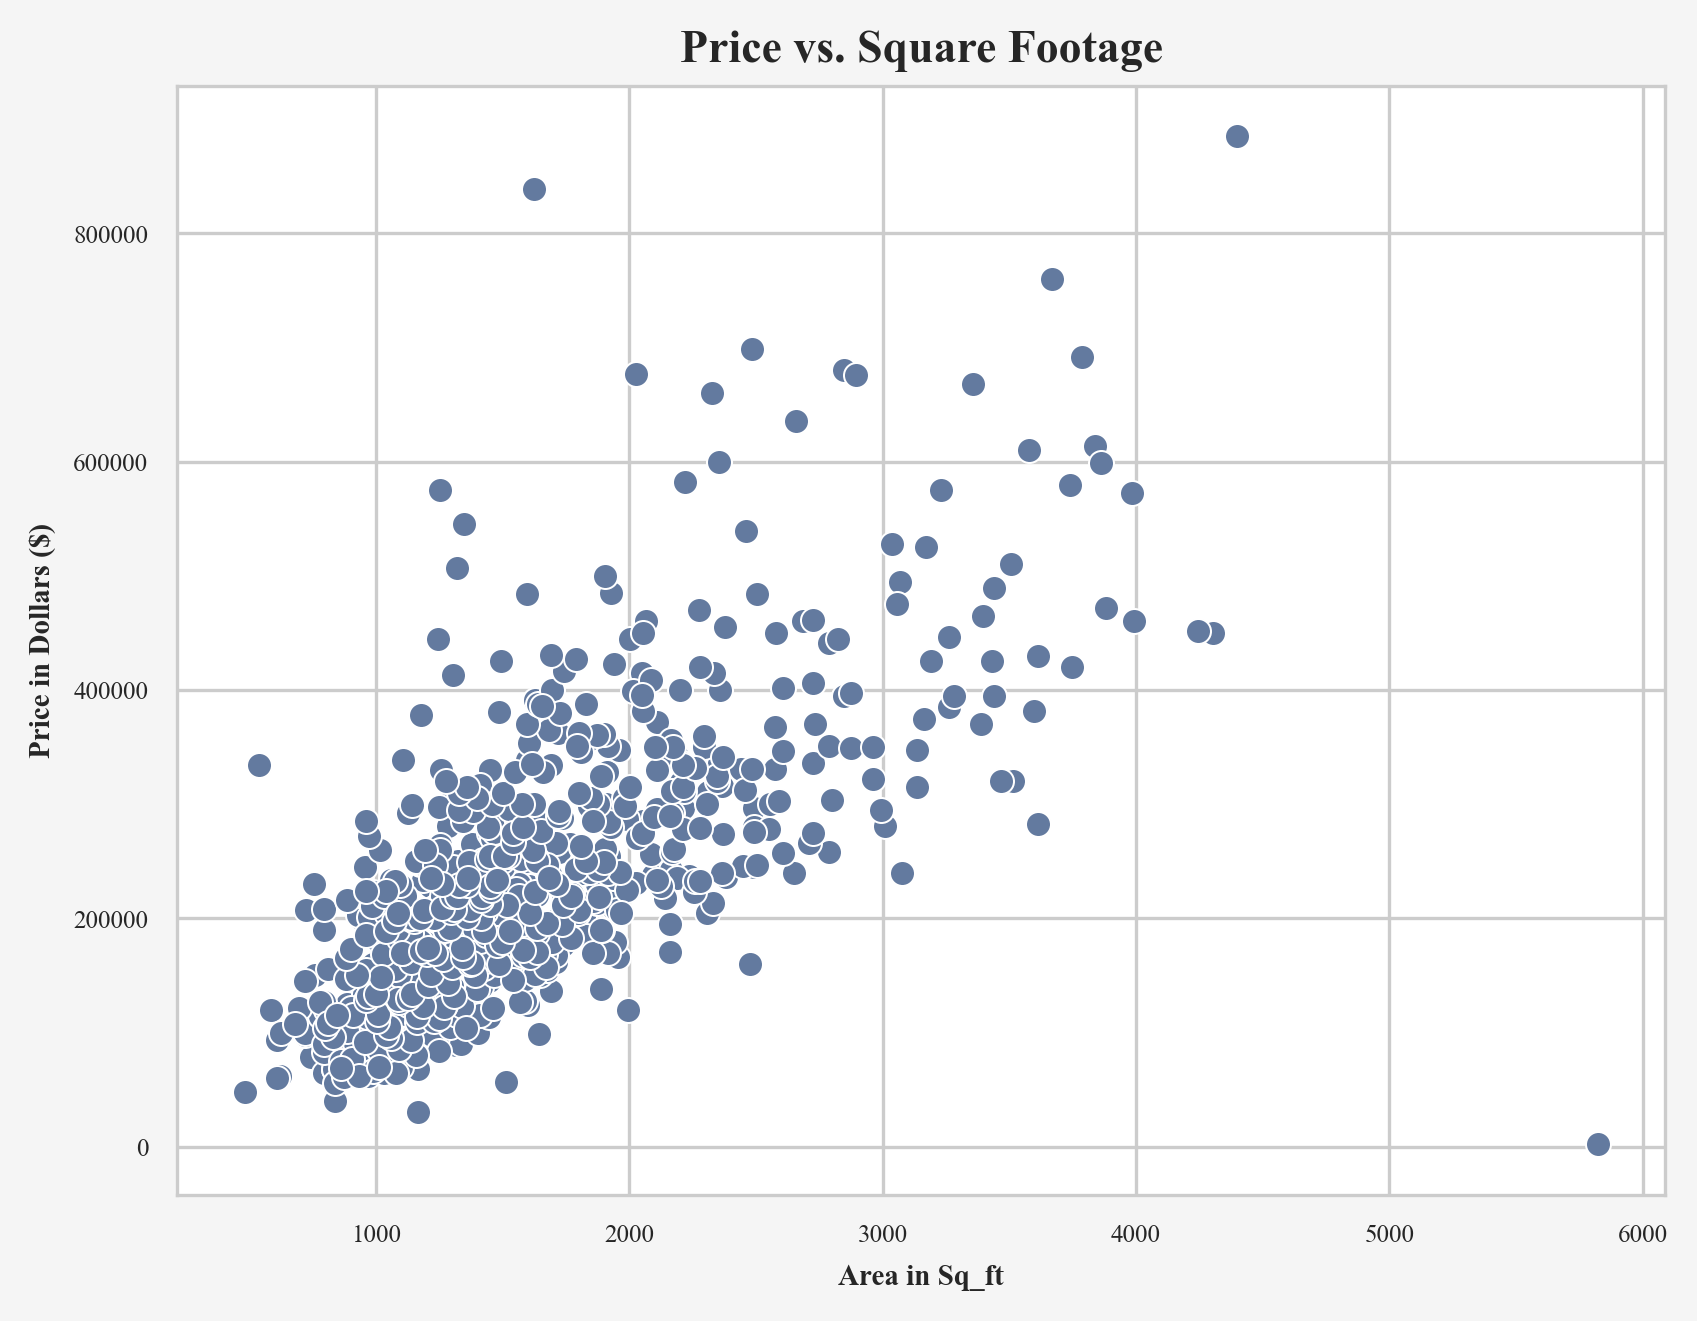

In [9]:
plt.figure(facecolor='whitesmoke', dpi=300)
plt.title('Price vs. Square Footage', fontweight='bold', fontsize=11)
sns.scatterplot(data=df, x='sq_ft', y='price', color='#637A9F')
plt.ylabel('Price in Dollars ($)', fontweight='bold', fontsize=7)
plt.xlabel('Area in Sq_ft', fontweight='bold', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

There is a house with an area of 5822 square feet (the largest in the dataset) whose price is close to zero. This could mean that either the price or the area of the house was entered incorrectly. Since it is an outlier and may negatively affect the model, we will remove it.

In [10]:
outlier = df.loc[df['sq_ft'] == np.max(df['sq_ft'])]
df = df.drop(outlier.index)

In [11]:
df.reset_index(inplace=True, drop=True)
df.count()

city     813
zip      813
bed      813
bath     813
sq_ft    813
type     813
price    813
lat      813
long     813
dtype: int64

In [12]:
num_cols = ['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long', 'price']
cat_cols = ['city', 'type']

We use One-Hot Encoding to convert categorical data into a numerical form. (Label Encoding is suitable only if there is an intrinsic order in the categories)

In [13]:
cat_dummies = pd.get_dummies(df[cat_cols]).astype(int)
df_encoded = df.drop(columns=cat_cols)
df_encoded = pd.concat([df_encoded.drop(columns=['price']), cat_dummies, df_encoded['price']],
               axis='columns') # Also put 'Price' at the end as it is the response variable - optional
df_encoded.head()

zip  bed  bath  sq_ft        lat        long  city_ANTELOPE  city_AUBURN  \
0  95838    2     1    836  38.631913 -121.434879              0            0   
1  95823    3     1   1167  38.478902 -121.431028              0            0   
2  95815    2     1    796  38.618305 -121.443839              0            0   
3  95815    2     1    852  38.616835 -121.439146              0            0   
4  95824    2     1    797  38.519470 -121.435768              0            0   

   city_CAMERON PARK  city_CARMICHAEL  ...  city_ROCKLIN  city_ROSEVILLE  \
0                  0                0  ...             0               0   
1                  0                0  ...             0               0   
2                  0                0  ...             0               0   
3                  0                0  ...             0               0   
4                  0                0  ...             0               0   

   city_SACRAMENTO  city_WALNUT GROVE  city_WEST SACRAMENTO  city_WILTON  \
0                1                  0                     0            0   
1                1                  0                     0            0   
2                1                  0                     0            0   
3                1                  0                     0            0   
4                1                  0                     0            0   

   type_Condo  type_Multi-Family  type_Residential  price  
0           0                  0                 1  59222  
1           0                  0                 1  68212  
2           0                  0                 1  68880  
3           0                  0                 1  69307  
4           0                  0                 1  81900  

[5 rows x 45 columns]

In [14]:
#Data Splitting And Normalization
seed = 666
df_train, df_test = train_test_split(df_encoded, test_size=0.2, random_state=seed)

X_train = df_train.drop(columns=['price'])
y_train = df_train['price']

X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']])
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled).reset_index(drop=True),
                           X_train.drop(columns=['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']).reset_index(drop=True)],
                           axis='columns')
X_train_scaled = X_train_scaled.to_numpy()

X_test_scaled = scaler.transform(X_test[['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']])
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled).reset_index(drop=True),
                           X_test.drop(columns=['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']).reset_index(drop=True)],
                           axis='columns')
X_test_scaled = X_test_scaled.to_numpy()

In [15]:
df_est, df_val = train_test_split(df_train, test_size=0.25, random_state=seed)

X_est = df_est.drop(columns=['price'])
y_est = df_est['price']

X_val = df_val.drop(columns=['price'])
y_val = df_val['price']

scaler = StandardScaler() #Different scaler for estimation and validation sets

X_est_scaled = scaler.fit_transform(X_est[['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']])
X_est_scaled = pd.concat([pd.DataFrame(X_est_scaled).reset_index(drop=True),
                           X_est.drop(columns=['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']).reset_index(drop=True)],
                           axis='columns')
X_est_scaled = X_est_scaled.to_numpy()

X_val_scaled = scaler.transform(X_val[['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']])
X_val_scaled = pd.concat([pd.DataFrame(X_val_scaled).reset_index(drop=True),
                           X_val.drop(columns=['zip', 'bed', 'bath', 'sq_ft', 'lat', 'long']).reset_index(drop=True)],
                           axis='columns')
X_val_scaled = X_val_scaled.to_numpy()

## 2. EDA

### 2.1. EDA Univariate Analysis

zip
Skew : -0.67


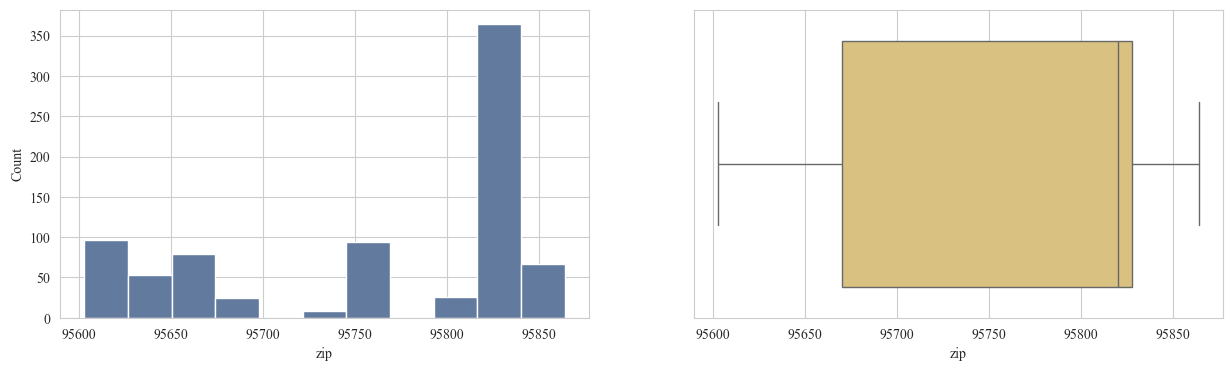

bed
Skew : 0.31


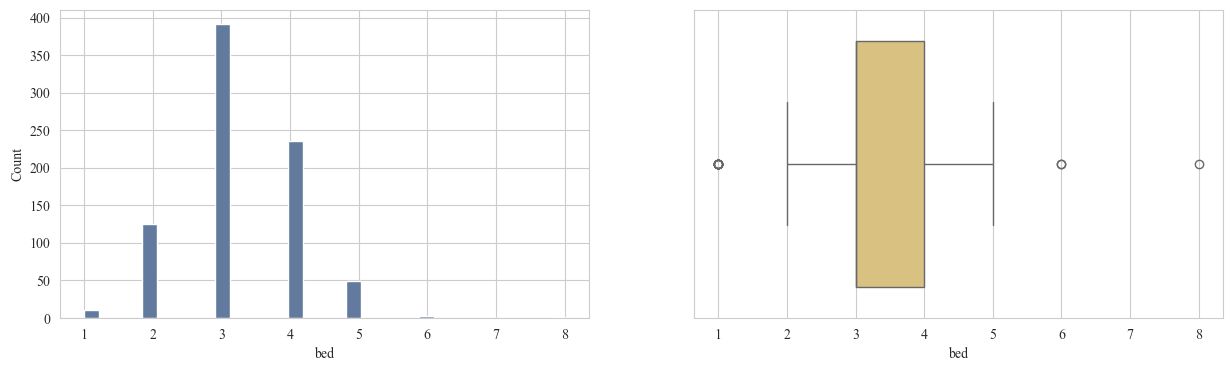

bath
Skew : 0.55


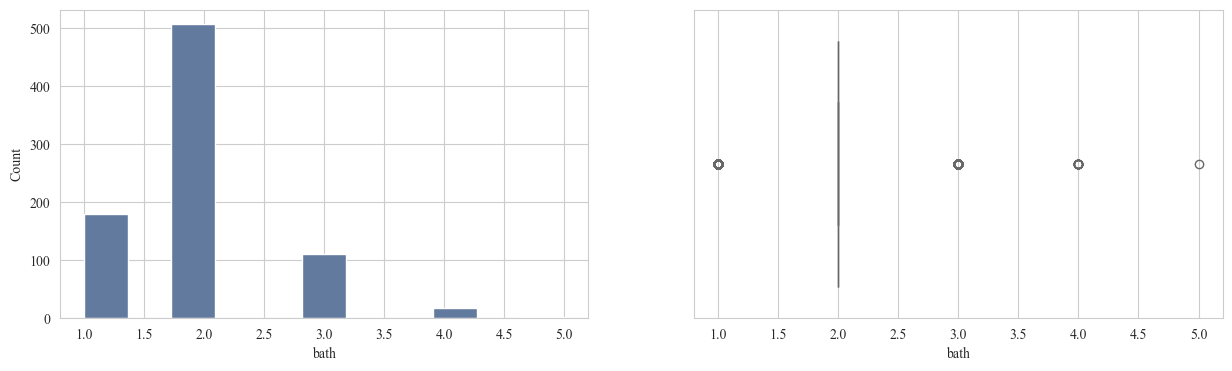

sq_ft
Skew : 1.48


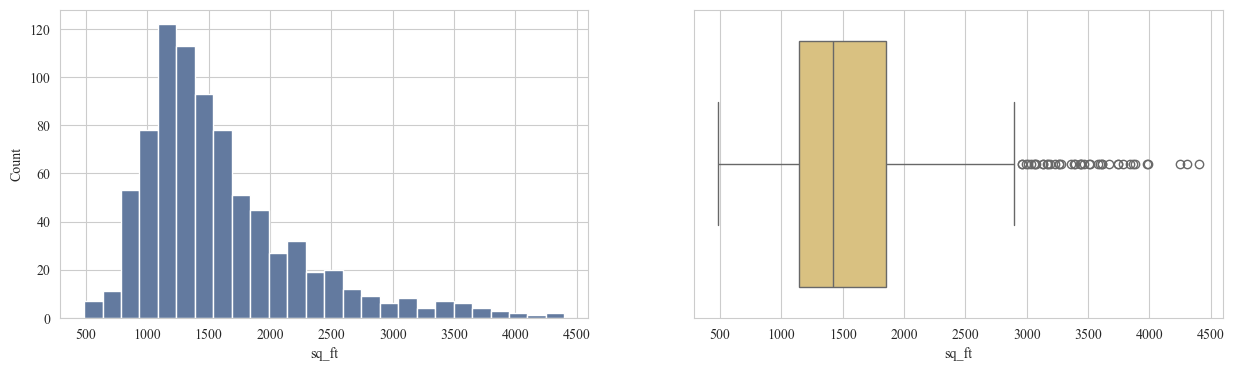

lat
Skew : -0.08


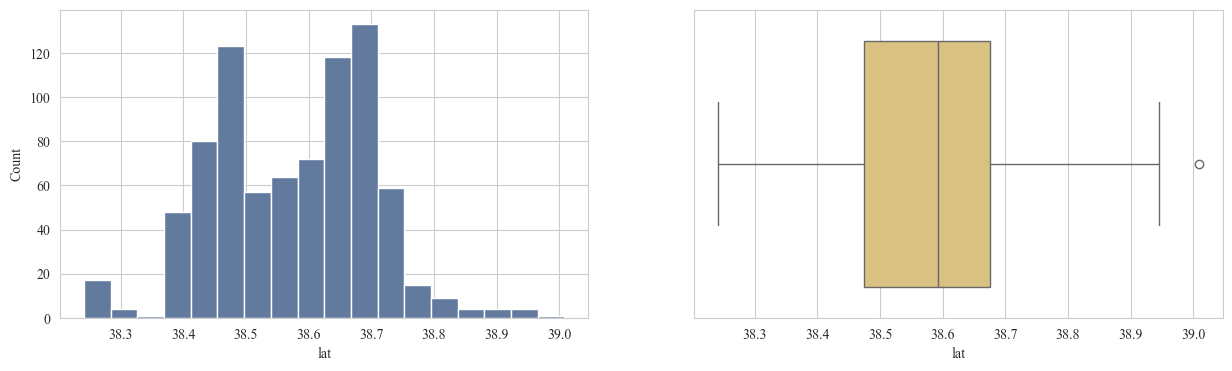

long
Skew : 2.33


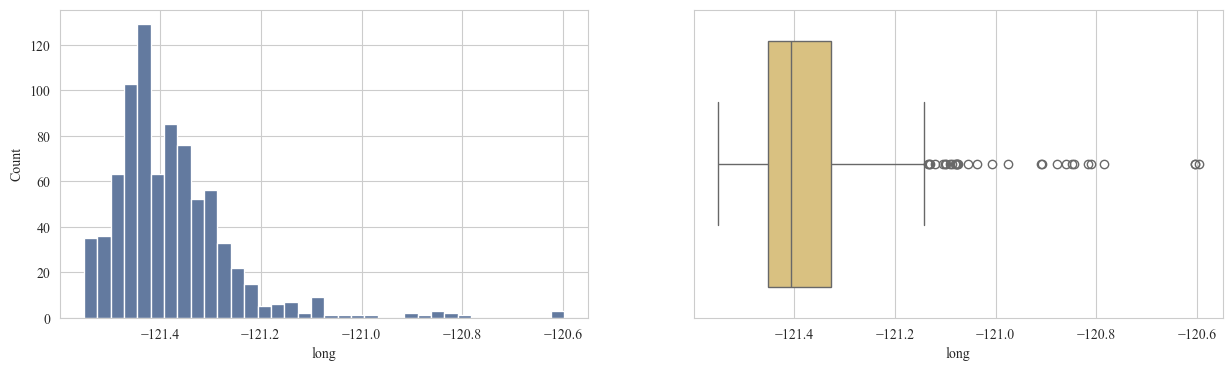

price
Skew : 1.52


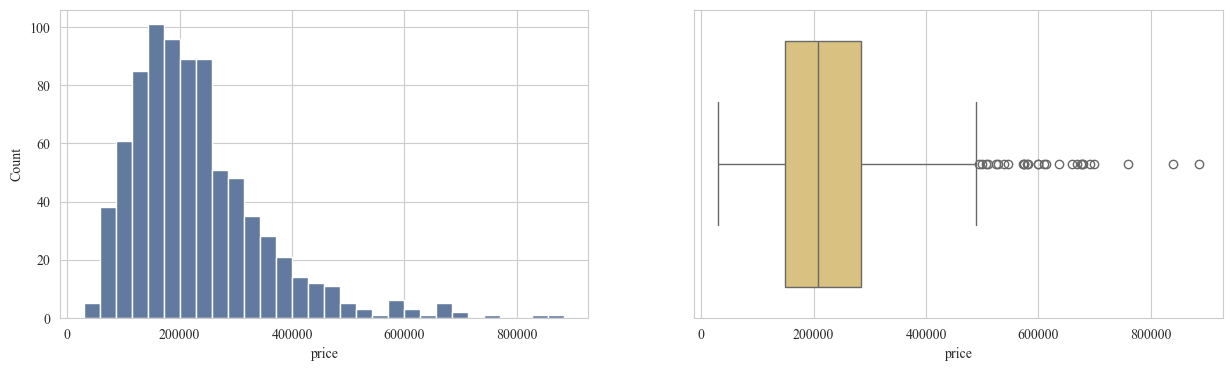

In [16]:
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], color='#637A9F', alpha=1)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='#E8C872')
    plt.show()

- Zip code, number of bedrooms, and number of bathrooms do not follow a specific distribution.<br>
- Sq_ft, price, and longitude come from a right-skewed distribution and have many outliers

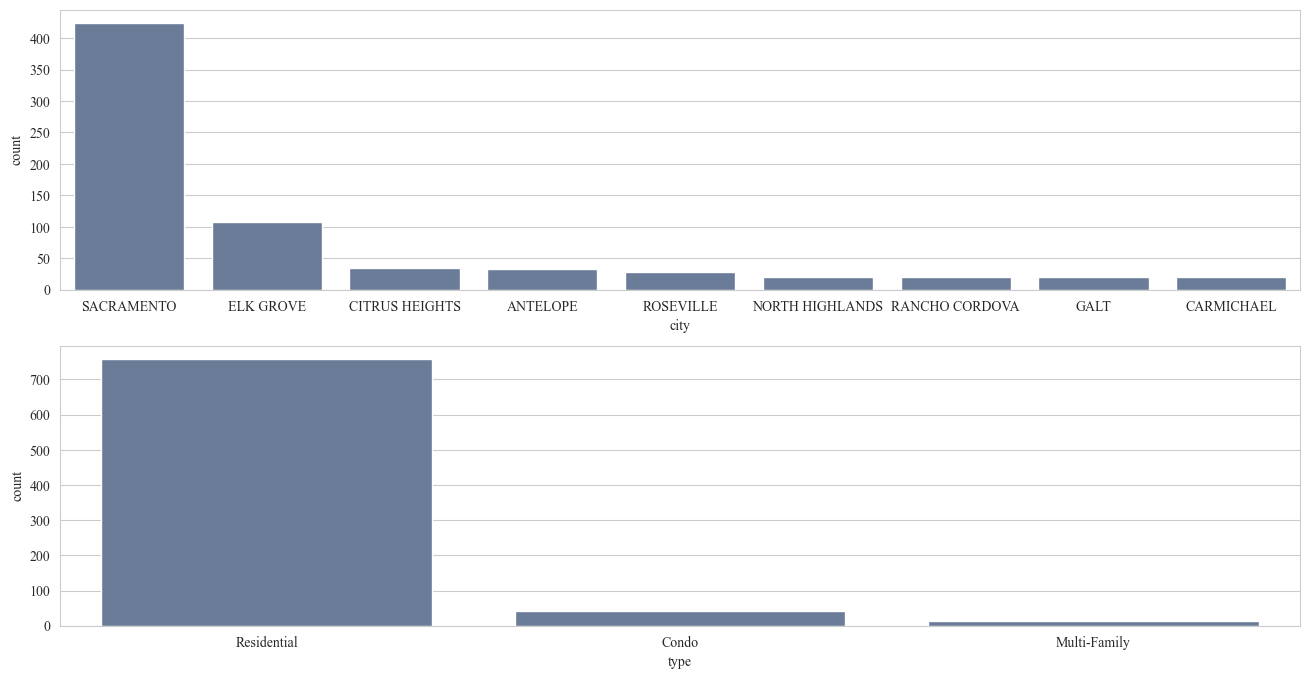

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))

for i, x in enumerate(cat_cols):
    sns.countplot(data=df, x=x, ax=ax[i], order=df[x].value_counts().iloc[:9].index, color='#637A9F');

- Most of the houses are located in Sacramento and are residential.<br>
- Very few of the houses are multi-family.

### 2.2. EDA Bivariate Analysis

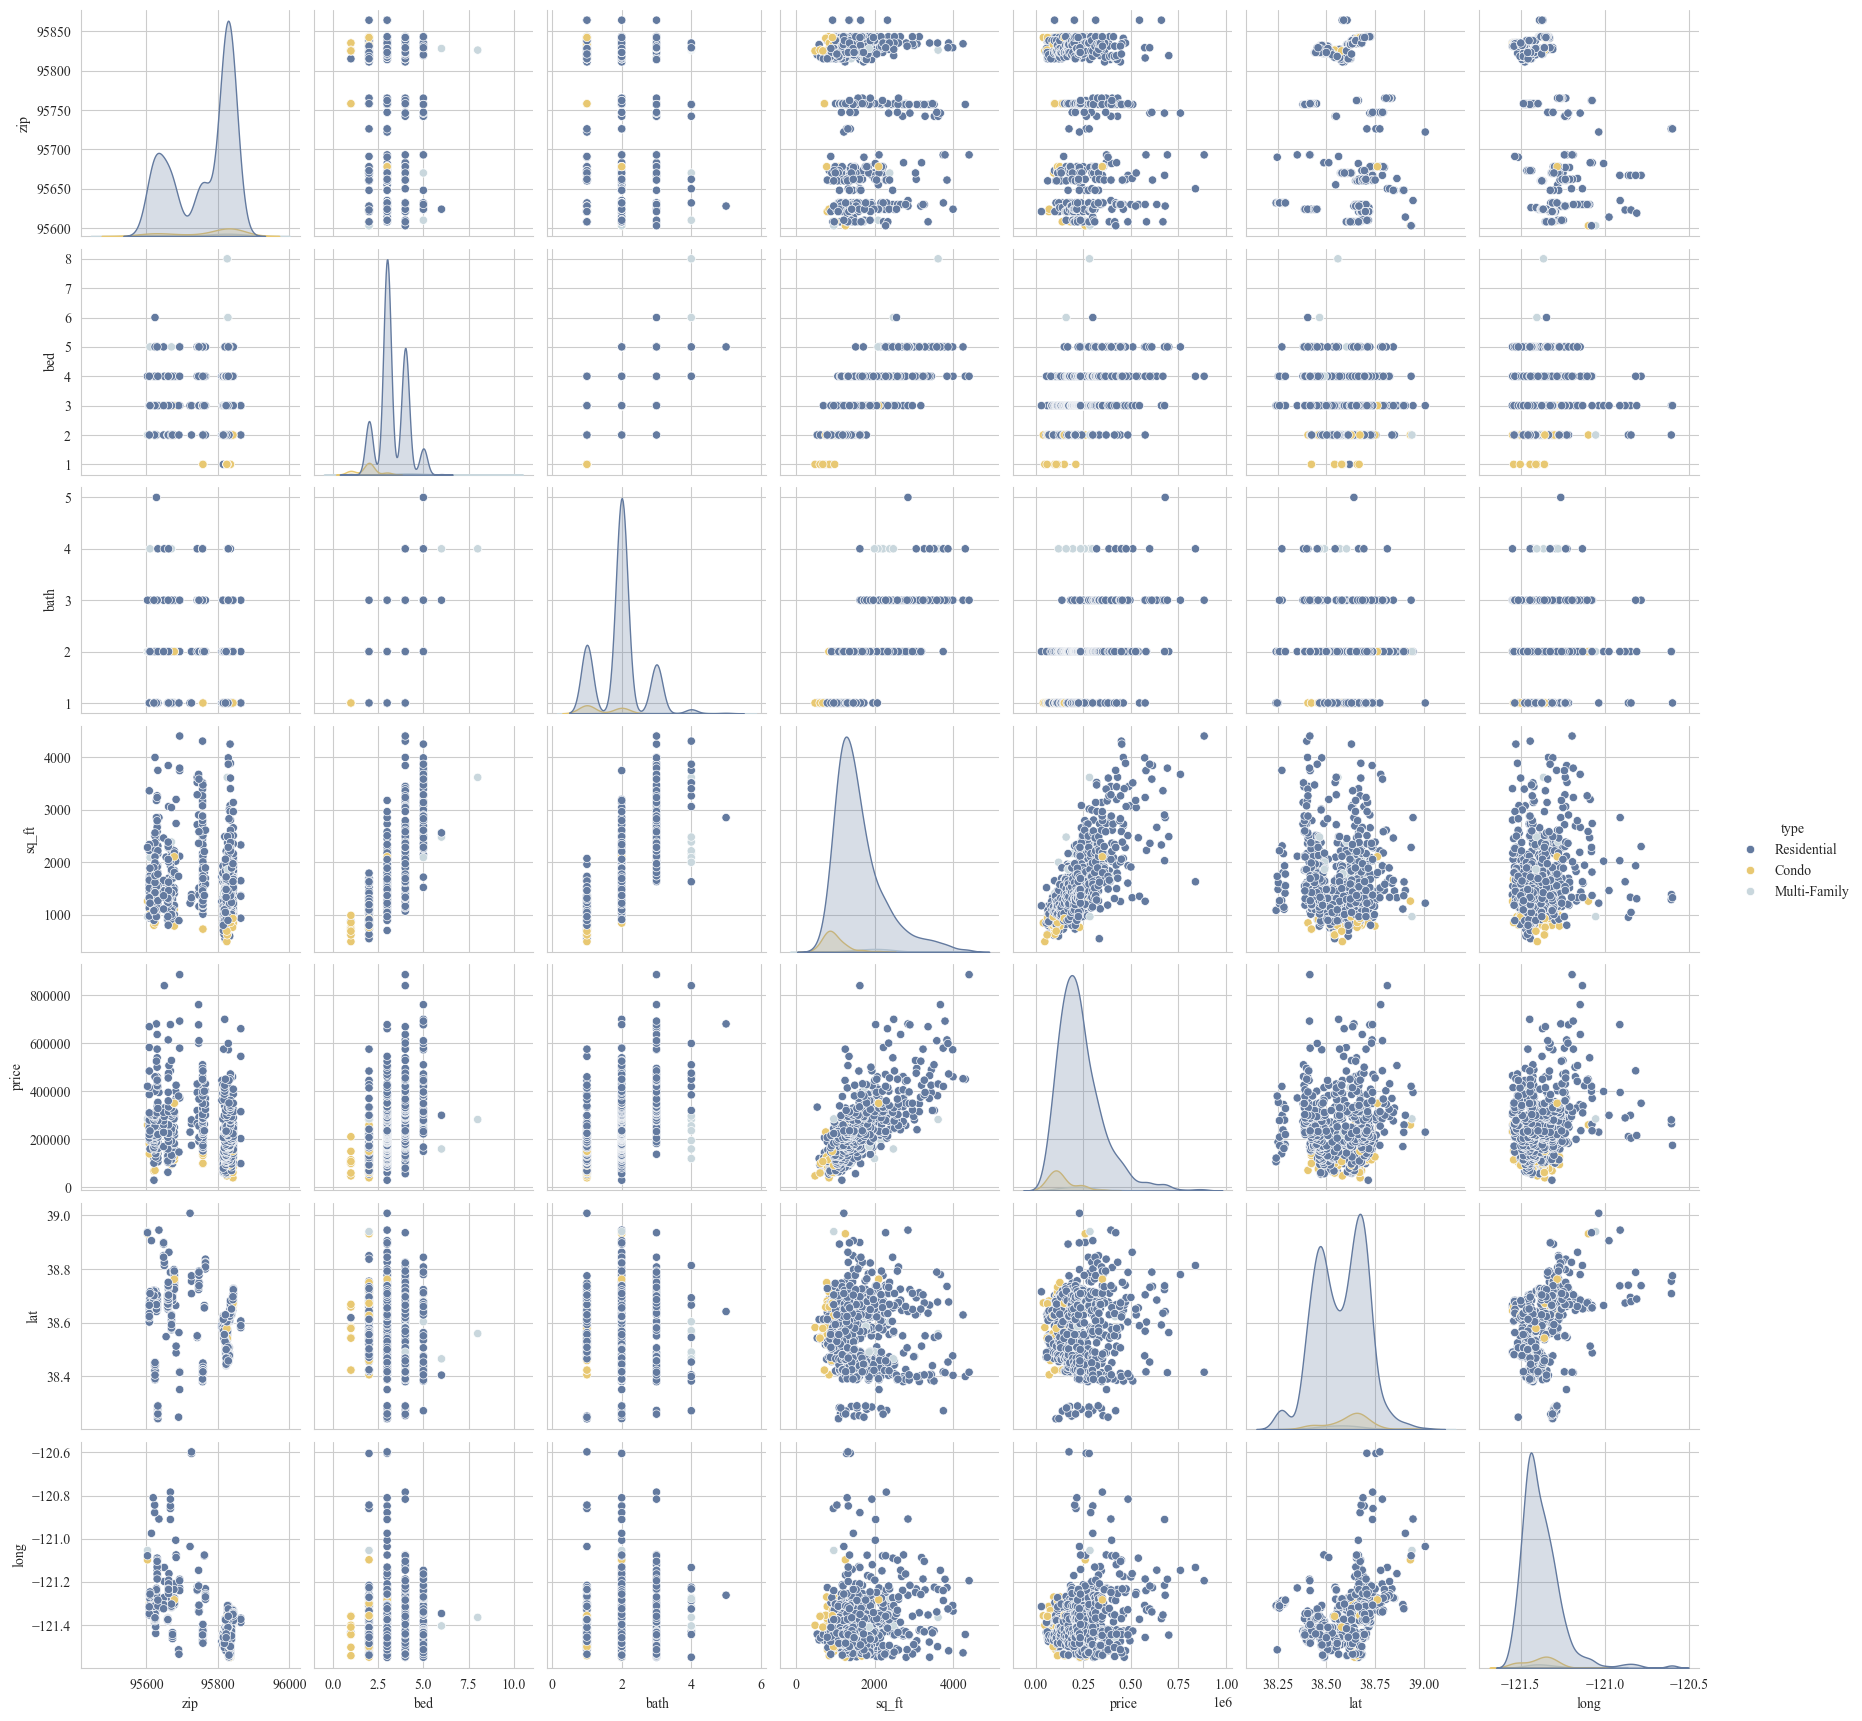

In [18]:
sns.pairplot(df, hue='type', palette=['#637A9F','#E8C872','#C9D7DD']);

- There is a positive linear relationship between price and square footage. <br>
- There is also a good relationship between the number of bedrooms and bathrooms with the house's sq_ft.

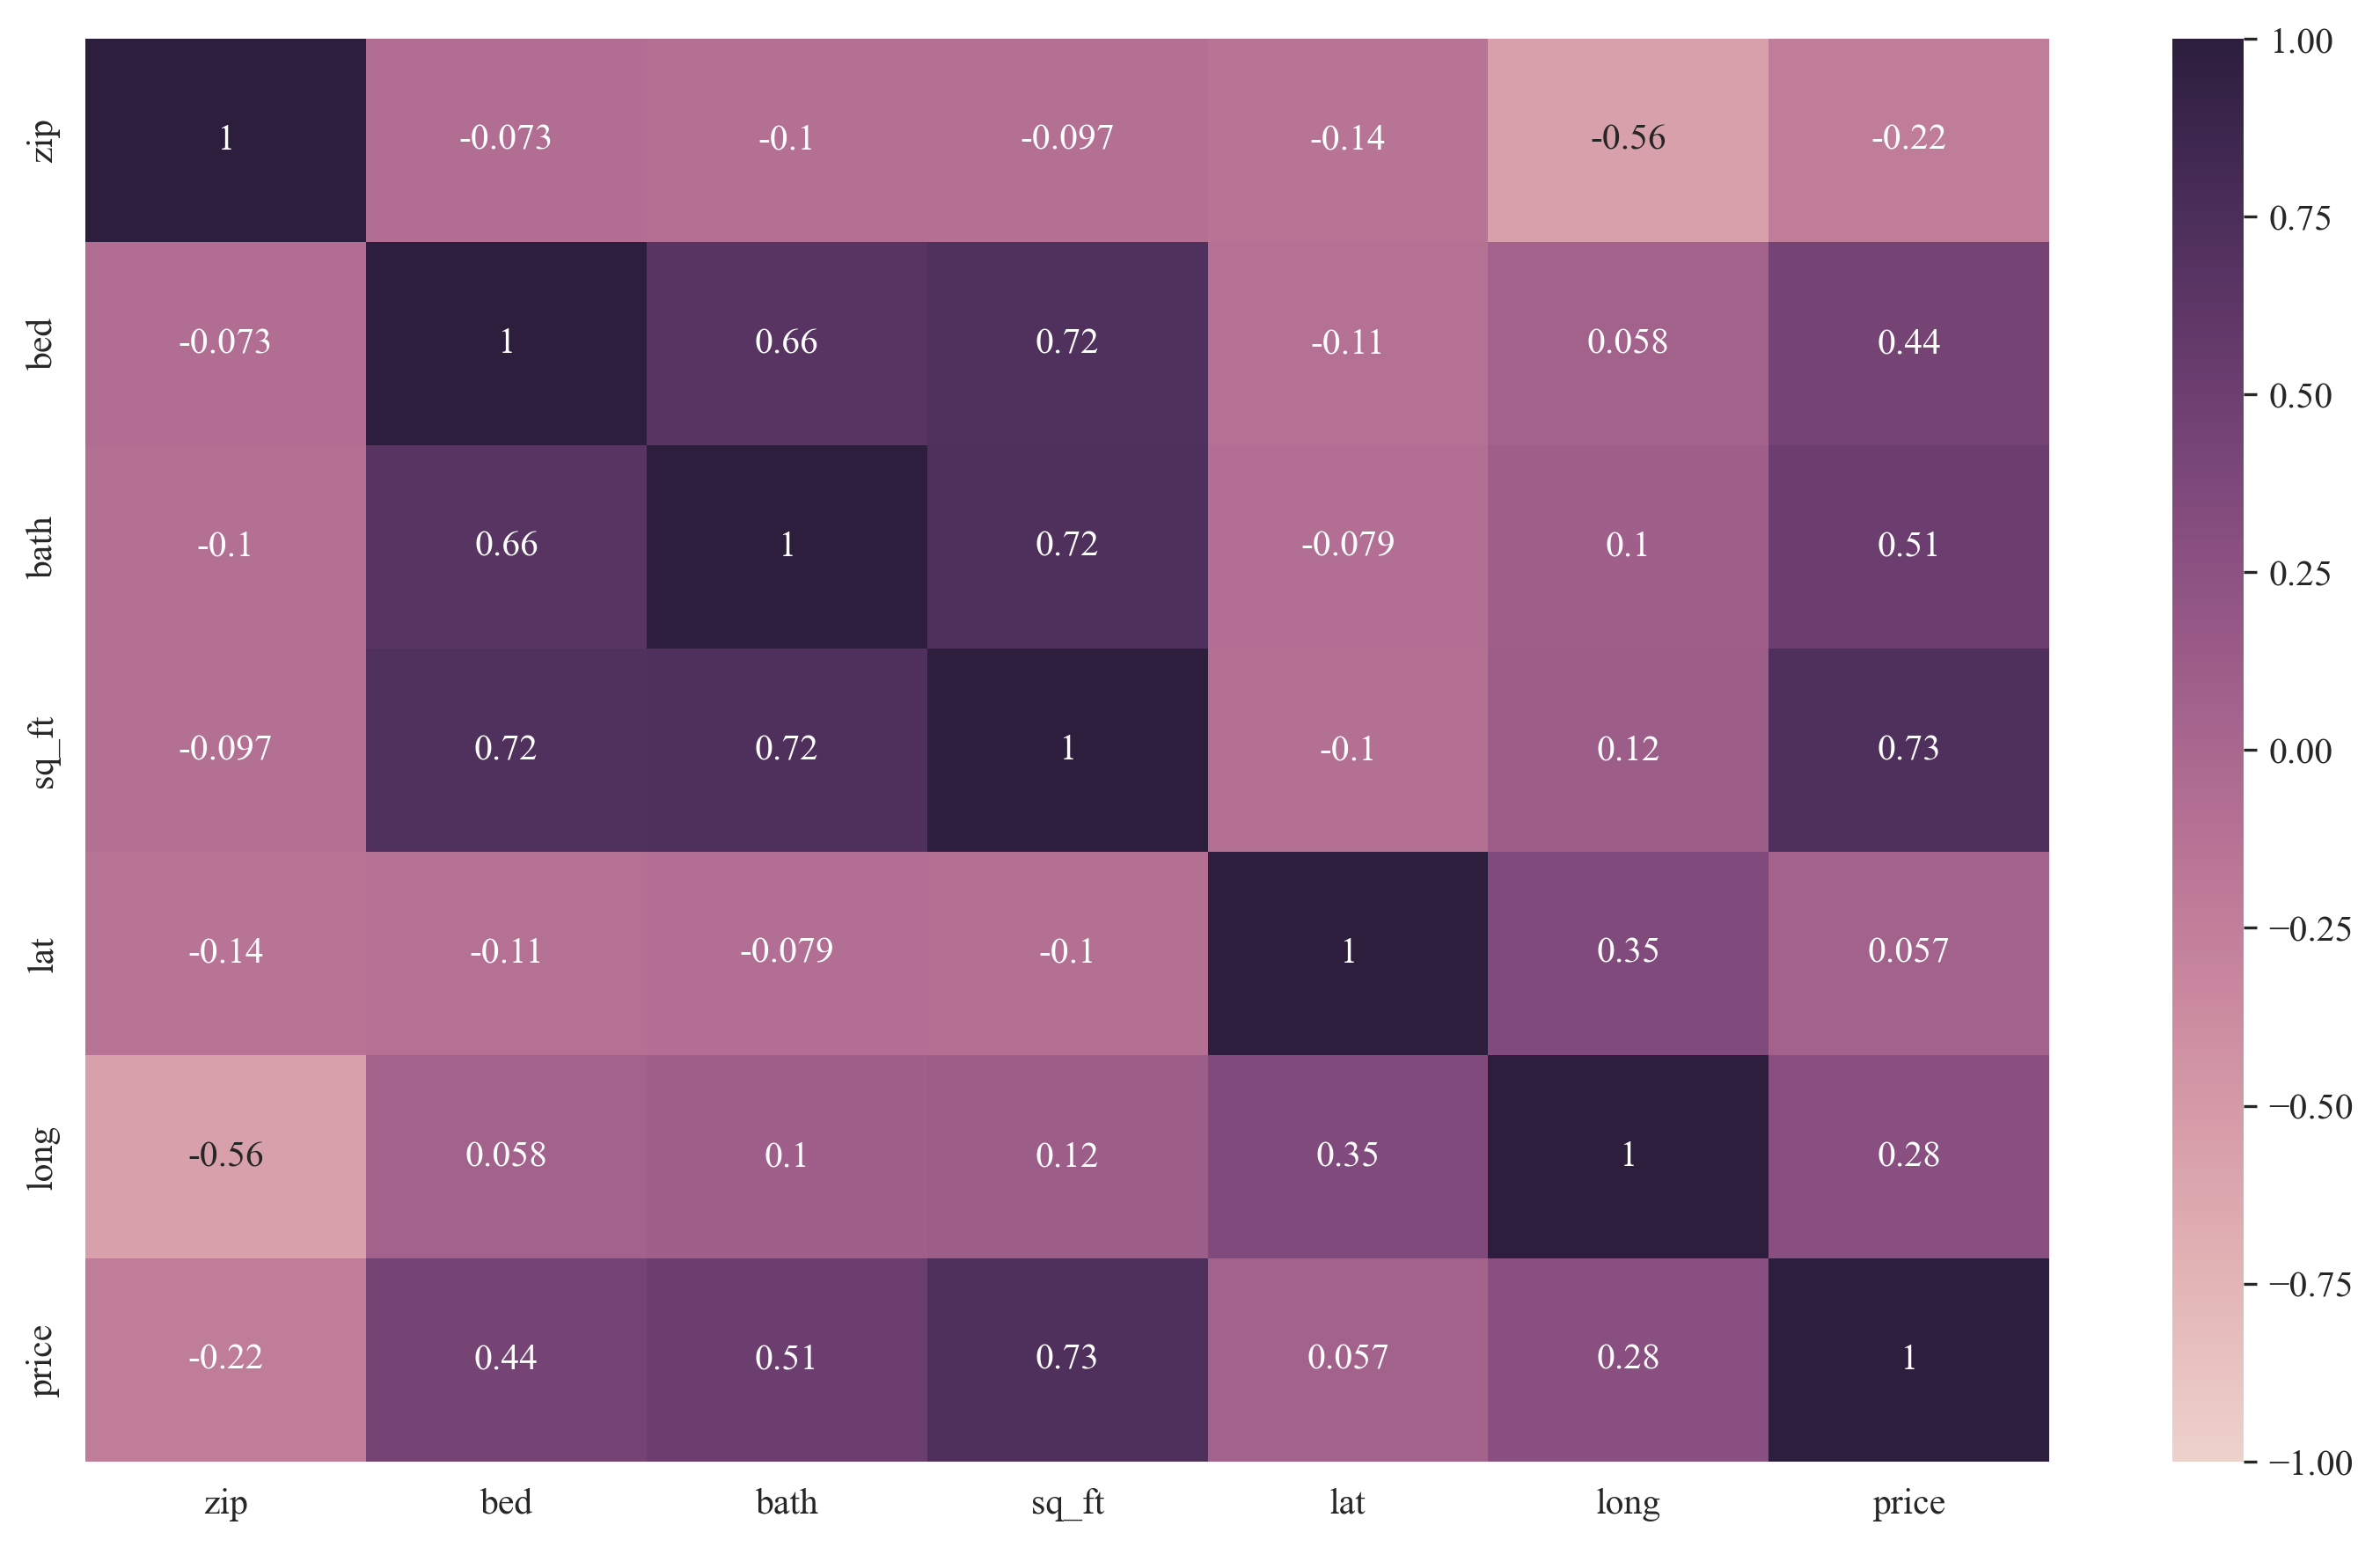

In [19]:
plt.figure(figsize=(12, 7), dpi=300)
sns.heatmap(df[num_cols].corr(), annot=True, vmin=-1, vmax=1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

- The strongest correlation is between price and house sq_ft.(0.73) <br>
- There is also a good positive correlation between the number of bathrooms and bedrooms with sq_ft.(0.72)<br>
- There is a relatively good correlation between the number of bedrooms and bathrooms.(0.66)

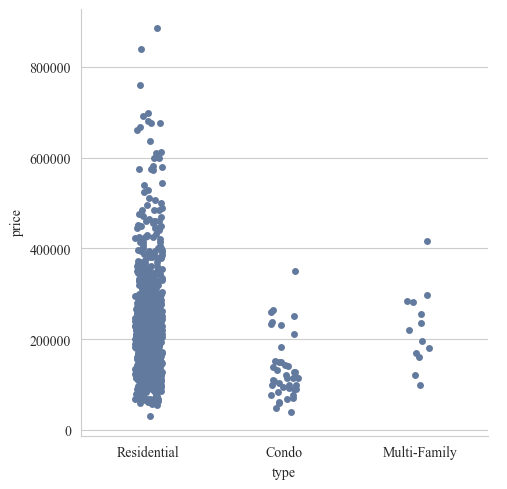

In [20]:
sns.catplot(data=df, x='type', y='price', color='#637A9F');

Residential houses tend to be more expensive than other types.

## 3. Linear And Polynomial Regressions

In general, OLS cares not about the scale of data; the coefficients will take care of the dimensional analysis and the relative importance for us.

In [22]:
df2 = df.copy()

df2 = pd.concat([df2.drop(columns=['price']), df2['price']], axis='columns')

train, test = train_test_split(df2, test_size=0.2, random_state=seed)

X_train_unscaled = train.drop(columns=['price'])
X_test_unscaled = test.drop(columns=['price'])

est, val = train_test_split(train, test_size=0.25, random_state=seed)

X_est_unscaled = est.drop(columns=['price'])
X_val_unscaled = val.drop(columns=['price'])

### 3.1. Simple Linear Regression

#### Model 1: Only sq_ft

In [23]:
mod_1 = sm.OLS.from_formula('price ~ sq_ft', data=est).fit() #Only Sq_ft feature as an input
y_val_pred = mod_1.predict(X_val_unscaled)
mod_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     643.8
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           5.20e-91
Time:                        21:22:10   Log-Likelihood:                -6141.1
No. Observations:                 487   AIC:                         1.229e+04
Df Residuals:                     485   BIC:                         1.229e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9689.7519   9045.387      1.071      0.285   -8083.233    2.75e+04
sq_ft        136.7770      5.391     25.373      0.000     126.185     147.369
==============================================================================
Omnibus:                      110.818   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              266.049
Skew:                           1.153   Prob(JB):                     1.69e-58
Kurtosis:                       5.792   Cond. No.                     4.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 90498.94380144162
Validation NSE: 0.5189241891332446
Validation R2 Score: 0.5189241891332446
Validation MAE: 67540.27155683194


### 3.2. Multiple Linear Regression

#### Model 2: Sq_ft, Lattitude and Longitude

In [25]:
mod_2 = sm.OLS.from_formula('price ~ sq_ft + lat + long', data=est).fit()
y_val_pred = mod_2.predict(X_val_unscaled)
mod_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     235.6
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           3.83e-94
Time:                        21:22:14   Log-Likelihood:                -6127.3
No. Observations:                 487   AIC:                         1.226e+04
Df Residuals:                     483   BIC:                         1.228e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.603e+07   4.16e+06      3.849      0.000    7.84e+06    2.42e+07
sq_ft        132.7775      5.413     24.529      0.000     122.141     143.414
lat         2.057e+04   2.84e+04      0.724      0.469   -3.52e+04    7.64e+04
long        1.384e+05   2.99e+04      4.626      0.000    7.96e+04    1.97e+05
==============================================================================
Omnibus:                      119.823   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              310.482
Skew:                           1.212   Prob(JB):                     3.80e-68
Kurtosis:                       6.070   Cond. No.                     2.19e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 86742.81715458808
Validation NSE: 0.5580292334684845
Validation R2 Score: 0.5580292334684845
Validation MAE: 63236.984597269504


#### Model 3: All the features

In [27]:
mod_3 = sm.OLS.from_formula('price ~ ' + '+'.join(est.columns[:-1]), data=est).fit()
y_val_pred = mod_3.predict(X_val_unscaled)
mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     25.32
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           2.70e-87
Time:                        21:22:17   Log-Likelihood:                -6072.3
No. Observations:                 487   AIC:                         1.222e+04
Df Residuals:                     449   BIC:                         1.238e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -9.43e+06   1.44e+07     -0.656      0.512   -3.77e+07    1.88e+07
city[T.AUBURN]           1.153e+05   7.82e+04      1.474      0.141   -3.84e+04    2.69e+05
city[T.CARMICHAEL]       1.078e+05   3.95e+04      2.727      0.007    3.01e+04    1.85e+05
city[T.CITRUS HEIGHTS]   2.114e+04   3.68e+04      0.575      0.566   -5.11e+04    9.34e+04
city[T.COOL]             1.221e+05   7.87e+04      1.552      0.121   -3.25e+04    2.77e+05
city[T.DIAMOND SPRINGS]  7.244e+04    8.1e+04      0.894      0.372   -8.68e+04    2.32e+05
city[T.EL DORADO]         8.54e+04   8.01e+04      1.066      0.287    -7.2e+04    2.43e+05
city[T.EL DORADO HILLS]  1.008e+05   5.32e+04      1.895      0.059   -3729.056    2.05e+05
city[T.ELK GROVE]        4.401e+04   2.87e+04      1.534      0.126   -1.24e+04       1e+05
city[T.ELVERTA]         -2.453e+04   5.77e+04     -0.425      0.671   -1.38e+05     8.9e+04
city[T.FAIR OAKS]        1.221e+05   4.26e+04      2.868      0.004    3.85e+04    2.06e+05
city[T.FOLSOM]           1.458e+05   4.09e+04      3.564      0.000    6.54e+04    2.26e+05
city[T.GALT]              4.72e+04   4.33e+04      1.089      0.277    -3.8e+04    1.32e+05
city[T.GOLD RIVER]       1.085e+05   5.49e+04      1.977      0.049     647.073    2.16e+05
city[T.GRANITE BAY]      3.319e+05   6.95e+04      4.772      0.000    1.95e+05    4.69e+05
city[T.GREENWOOD]        3.979e+04   8.08e+04      0.493      0.623   -1.19e+05    1.99e+05
city[T.LINCOLN]          5.531e+04   4.37e+04      1.265      0.206   -3.06e+04    1.41e+05
city[T.MEADOW VISTA]     8.375e+04   7.45e+04      1.125      0.261   -6.26e+04     2.3e+05
city[T.NORTH HIGHLANDS] -1.562e+04    3.5e+04     -0.446      0.656   -8.45e+04    5.33e+04
city[T.ORANGEVALE]       8.102e+04   3.96e+04      2.043      0.042    3096.504    1.59e+05
city[T.PLACERVILLE]       1.66e+05   5.87e+04      2.827      0.005    5.06e+04    2.81e+05
city[T.POLLOCK PINES]    4.175e+04   8.61e+04      0.485      0.628   -1.27e+05    2.11e+05
city[T.RANCHO CORDOVA]   1.706e+04   3.17e+04      0.539      0.590   -4.52e+04    7.93e+04
city[T.RANCHO MURIETA]   4.684e+04    5.7e+04      0.822      0.411   -6.51e+04    1.59e+05
city[T.RIO LINDA]          2.4e+04   3.67e+04      0.654      0.514   -4.82e+04    9.62e+04
city[T.ROCKLIN]          8.724e+04   5.07e+04      1.721      0.086   -1.24e+04    1.87e+05
city[T.ROSEVILLE]        7.595e+04   3.12e+04      2.436      0.015    1.47e+04    1.37e+05
city[T.SACRAMENTO]       8298.6763   1.94e+04      0.428      0.669   -2.98e+04    4.64e+04
city[T.WEST SACRAMENTO]  1.981e+04   7.28e+04      0.272      0.786   -1.23e+05    1.63e+05
city[T.WILTON]           1.316e+05   5.61e+04      2.346      0.019    2.13e+04    2.42e+05
type[T.Multi-Family]    -2.751e+04   3.16e+04  

In [28]:
print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 77670.87013460005
Validation NSE: 0.6456415117330966
Validation R2 Score: 0.6456415117330966
Validation MAE: 55377.835722487194


#### Model 4: All the features with interactions

In [29]:
mod_4 = sm.OLS.from_formula('price ~ (' + '+'.join(est.columns[0:-1]) + ')**2', data=est).fit()
y_val_pred = mod_4.predict(X_val_unscaled)
mod_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     8.073
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           3.78e-56
Time:                        21:22:20   Log-Likelihood:                -5991.7
No. Observations:                 487   AIC:                         1.227e+04
Df Residuals:                     345   BIC:                         1.286e+04
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     6.822e+05   1.08e+06      0.634      0.527   -1.43e+06     2.8e+06
city[T.AUBURN]                               -1.905e+05   1.21e+06     -0.158      0.875   -2.57e+06    2.18e+06
city[T.CARMICHAEL]                            3.774e+04   1.26e+05      0.300      0.765    -2.1e+05    2.85e+05
city[T.CITRUS HEIGHTS]                        2.875e+08   5.59e+08      0.514      0.607   -8.12e+08    1.39e+09
city[T.COOL]                                   493.6231   1158.055      0.426      0.670   -1784.113    2771.359
city[T.DIAMOND SPRINGS]                       -213.1581   1764.742     -0.121      0.904   -3684.166    3257.850
city[T.EL DORADO]                             -792.7453   2458.573     -0.322      0.747   -5628.423    4042.932
city[T.EL DORADO HILLS]                        -26.3657    365.694     -0.072      0.943    -745.636     692.905
city[T.ELK GROVE]                            -3.072e+07   2.25e+08     -0.137      0.891   -4.73e+08    4.11e+08
city[T.ELVERTA]                               -585.8820   1541.080     -0.380      0.704   -3616.976    2445.212
city[T.FAIR OAKS]                             1295.9360   2662.684      0.487      0.627   -3941.202    6533.074
city[T.FOLSOM]                                -500.4361   1209.213     -0.414      0.679   -2878.793    1877.921
city[T.GALT]                                  -399.4156   1638.744     -0.244      0.808   -3622.601    2823.770
city[T.GOLD RIVER]                            -199.0543    441.577     -0.451      0.652   -1067.577     669.468
city[T.GRANITE BAY]                           -731.3734   1597.265     -0.458      0.647   -3872.976    2410.230
city[T.GREENWOOD]                             -559.2155   1262.344     -0.443      0.658   -3042.074    1923.643
city[T.LINCOLN]                               -102.9261    453.911     -0.227      0.821    -995.708     789.856
city[T.MEADOW VISTA]                          -857.2830   2273.113     -0.377      0.706   -5328.187    3613.621
city[T.NORTH HIGHLANDS]                        532.4257   1230.798      0.433      0.666   -1888.386    2953.238
city[T.ORANGEVALE]                             426.4302   1087.720      0.392      0.695   -1712.967    2565.827
city[T.PLACERVILLE]                            452.1252   1499.777      0.301      0.763   -2497.732    3401.982
city[T.POLLOCK PINES]                         -196.4840   1360.371     -0.144      0.885   -2872.149    2479.181
city[T.RANCHO CORDOVA]                       -3.819e+06   3.66e+08     -0.010      0.992   -7.23e+08    7.16e+08
city[T.RANCHO MURIETA]                        -405.7538   2774.151     -0.146      0.884   -5862.131    5050.623
city[T.RIO LINDA]               

In [30]:
print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 105240562.82589898
Validation NSE: -650567.1884459233
Validation R2 Score: -650567.1884459233
Validation MAE: 12477189.445367552


### 3.3. Polynomial Regression

#### Model 5+6: Polynomial with 2 and 3 degrees

In [31]:
degrees = [2, 3] #more than 3 is too large to be indexed by int64

for degree in degrees:
    lin = LinearRegression()
    ply = PolynomialFeatures(degree=degree)
    
    X_est_ply = ply.fit_transform(X_est_scaled)
    X_val_ply = ply.transform(X_val_scaled)
    
    ply.fit(X_est_ply, y_est)
    lin.fit(X_est_ply, y_est)
    
    y_val_pred = lin.predict(X_val_ply)

    print(f'Polynomial (Degree={degree})')
    print(f'====> RMSE: {calc_rmse(y_val, y_val_pred)}')
    print(f'====> NSE: {calc_nse(y_val, y_val_pred)}')
    print(f'====> R2 Score: {r2_score(y_val, y_val_pred)}')
    print(f'====> MAE: {mean_absolute_error(y_val, y_val_pred)}')

Polynomial (Degree=2)
====> RMSE: 295897.413501554
====> NSE: -4.14290896702665
====> R2 Score: -4.14290896702665
====> MAE: 101746.86815976628
Polynomial (Degree=3)
====> RMSE: 6673829.449451955
====> NSE: -2615.2347343507963
====> R2 Score: -2615.2347343507963
====> MAE: 1532019.6790024498


### 3.4. Fitting the best model with the training set

First, we select the best model according to the results of the previous steps.

| Validation Model | RMSE | NSE | R2 Score | MAE |
| --- | --- | --- | --- | --- |
| Model 1 | 90498.94 | 0.5189 | 0.5189 | 67540.27 |
| Model 2 | 86742.82 | 0.5580 | 0.5580 | 63236.98 |
| Model 3 | 877670.87 | 0.6456 | 0.6456 | 55377.84 |
| Model 4 | 105240562.83 | -650567.19 | -650567.19 | 12477189.45 |
| Model 5 | 295897.41 | -4.14 | -4.14 | 101746.87 |
| Model 6 | 6673829.45 | -2615.23 | -2615.23 | 1532019.68 |

third one is the best.

In [32]:
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)

y_train_pred = lin.predict(X_train_scaled)
y_test_pred = lin.predict(X_test_scaled)

LR_rmse_train = calc_rmse(y_train, y_train_pred)
LR_nse_train = calc_nse(y_train, y_train_pred)
LR_r2_train = r2_score(y_train, y_train_pred)
LR_mae_train = mean_absolute_error(y_train, y_train_pred)

LR_rmse = calc_rmse(y_test, y_test_pred)
LR_nse = calc_nse(y_test, y_test_pred)
LR_r2 = r2_score(y_test, y_test_pred)
LR_mae = mean_absolute_error(y_test, y_test_pred)

In [33]:
print('Train RMSE:', LR_rmse_train)
print('Train NSE:', LR_nse_train)
print('Train R2 Score:', LR_r2_train)
print('Train MAE:', LR_mae_train)

Train RMSE: 66146.57426404512
Train NSE: 0.6754991965987647
Train R2 Score: 0.6754991965987647
Train MAE: 47806.80352668095


In [34]:
print('Test RMSE:', LR_rmse)
print('Test NSE:', LR_nse)
print('Test R2 Score:', LR_r2)
print('Test MAE:', LR_mae)

Test RMSE: 87194.58560177579
Test NSE: 0.5641883587612697
Test R2 Score: 0.5641883587612697
Test MAE: 55760.645219410435


### 3.5. Residual Analysis

Residual plot analysis is used to assess the validity of linear regression models by plotting the residuals and checking whether the assumptions of linear regression models are met. The most important assumption of a linear regression model is that the error terms or residuals are independent and normally distributed.

In [35]:
residual_df = pd.DataFrame({'y':y_test,'pred':y_test_pred})
residual_df['resid'] = residual_df['y'] - residual_df['pred']

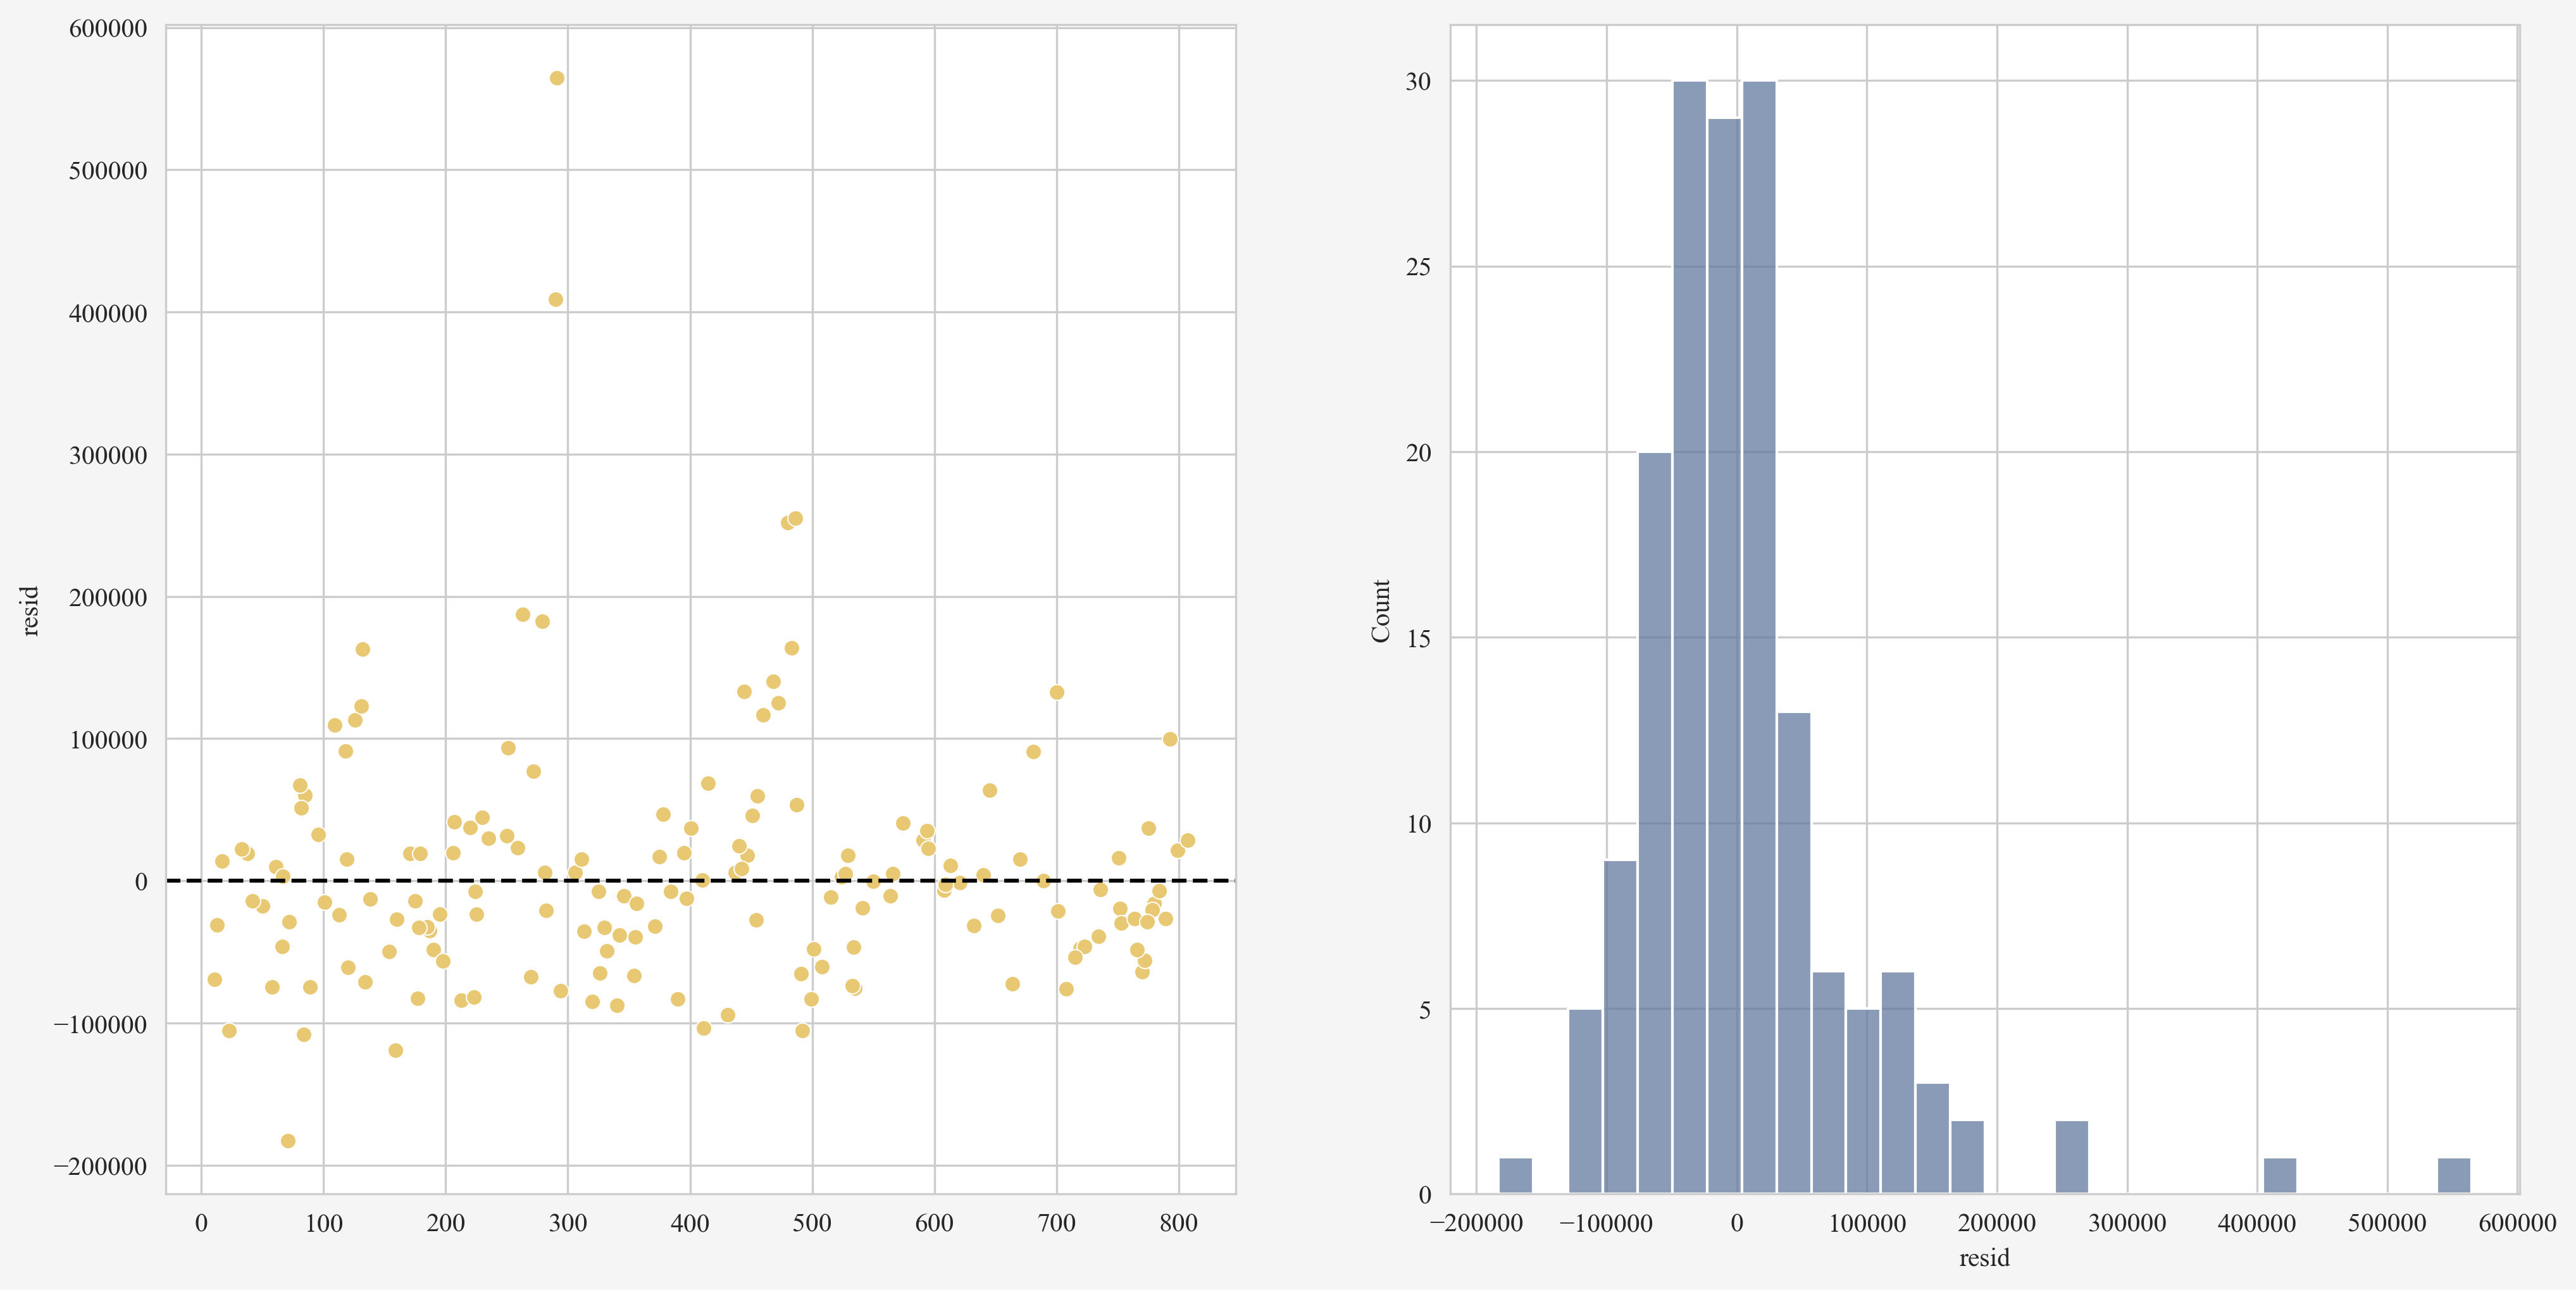

In [36]:
fig, ax = plt.subplots(1,2, figsize=(16,8), facecolor='whitesmoke', dpi=300)

sns.scatterplot(residual_df['resid'], ax=ax[0], color='#E8C872')
ax[0].axhline(0 ,linestyle='--', color='black')
sns.histplot(residual_df['resid'], ax=ax[1], color='#637A9F');

- Plot of residuals is not evenly distributed vertically and has some outliers. then it is safe to say our model has room for improvement And most likely it is not independent.<br>
- The histogram shows a rightly-skewed distribution. (it is not normally distributed)

## 4. K-Nearest Neighbors

### 4.1. Getting the optimal value of K

In [37]:
errors = []
r2_scores = []

for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_est_scaled, y_est)
    y_val_pred = knn.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    errors.append(mse)
    r2_scores.append(r2)

best_k = np.where(r2_scores == np.max(r2_scores))[0][0] + 1
print(f'Minimum of MSE is {np.min(errors)} | K = {best_k}')
print(f'Maximum of R2 score is {np.max(r2_scores)} | K = {best_k}')

Minimum of MSE is 6895729518.591003 | K = 3
Maximum of R2 score is 0.5949517898630834 | K = 3


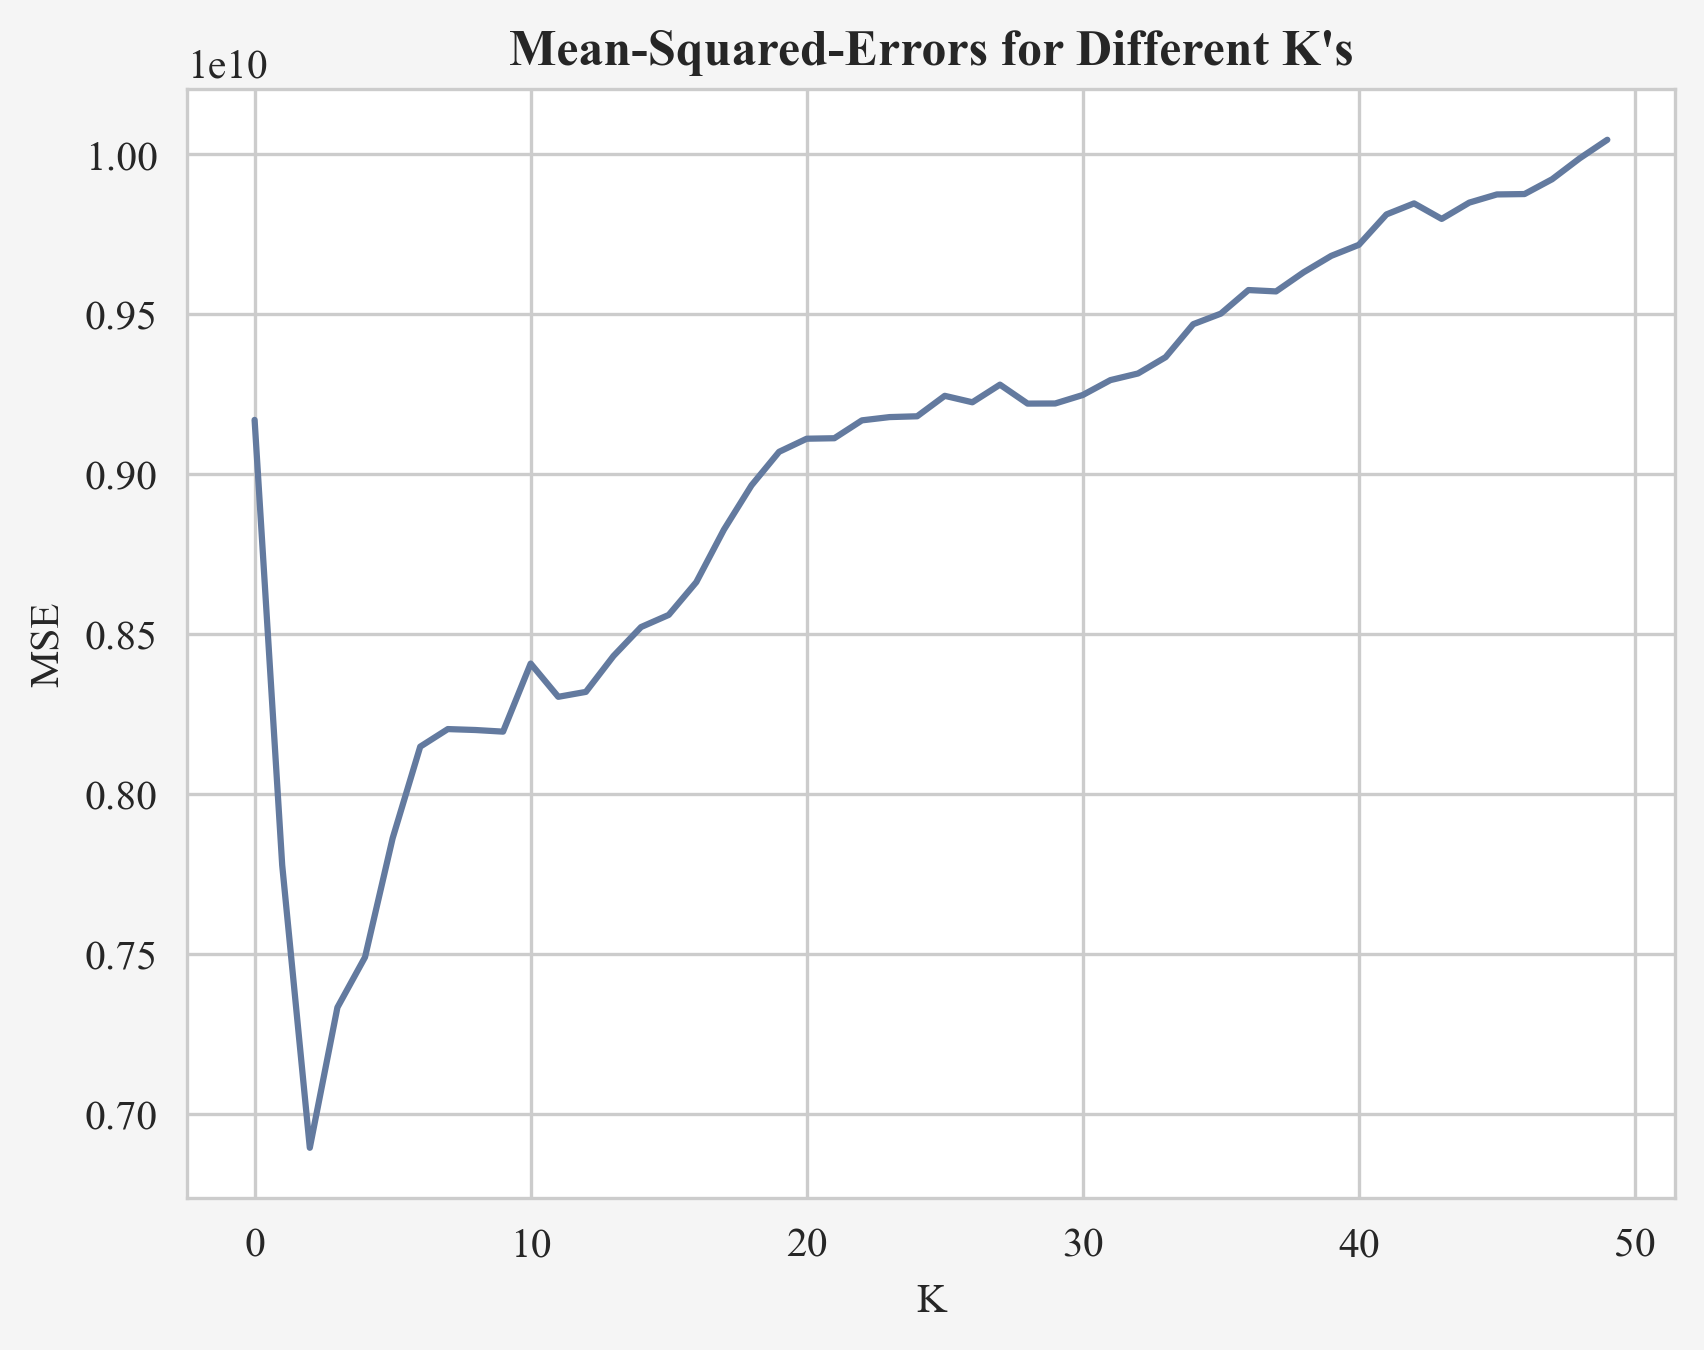

In [38]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(errors, color='#637A9F')
plt.title('Mean-Squared-Errors for Different K\'s', weight='bold')
plt.xlabel('K')
plt.ylabel('MSE');

### 4.2. Fitting the best model with the training set

In [63]:
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

y_test_pred = knn.predict(X_test_scaled)
y_train_pred = knn.predict(X_train_scaled)

KNN_rmse_train = calc_rmse(y_train, y_train_pred)
KNN_nse_train = calc_nse(y_train, y_train_pred)
KNN_r2_train = r2_score(y_train, y_train_pred)
KNN_mae_train = mean_absolute_error(y_train, y_train_pred)

KNN_rmse = calc_rmse(y_test, y_test_pred)
KNN_nse = calc_nse(y_test, y_test_pred)
KNN_r2 = r2_score(y_test, y_test_pred)
KNN_mae = mean_absolute_error(y_test, y_test_pred)

In [64]:
print('Train RMSE:', KNN_rmse_train)
print('Train NSE:', KNN_nse_train)
print('Train R2 Score:', KNN_r2_train)
print('Train MAE:', KNN_mae_train)

Train RMSE: 52633.80470104936
Train NSE: 0.7945384350068732
Train R2 Score: 0.7945384350068732
Train MAE: 38061.434358974366


In [65]:
print('Test RMSE:', KNN_rmse)
print('Test NSE:', KNN_nse)
print('Test R2 Score:', KNN_r2)
print('Test MAE:', KNN_mae)

Test RMSE: 88255.02931596414
Test NSE: 0.5535233839938677
Test R2 Score: 0.5535233839938677
Test MAE: 59984.39468302658


## 5. Regression Decision-Tree

### 5.1. Parameter tuning: max_depth

In [66]:
r2_scores = []

for depth in range(1,101):
    rgr = DecisionTreeRegressor(max_depth=depth,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_depth = np.where(r2_scores == max_score)[0][0] + 1

print(f'Best max_depth is {best_depth} with a R2 Score of {max_score}')

Best max_depth is 14 with a R2 Score of 0.46562781145398113


In [67]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 95380.29777546514
Validation NSE: 0.46562781145398113
Validation R2 Score: 0.46562781145398113
Validation MAE: 70403.25749829585


### 5.2. Parameter tuning: min_samples_split

According to the paper, An empirical study on hyperparameter tuning of decision trees, the ideal min_samples_split values tend to be between 1 to 40 for the CART algorithm which is the algorithm implemented in scikit-learn.

In [68]:
r2_scores = []

for sample_split in range(2,41):
    rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=sample_split,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_sample_split = np.where(r2_scores == max_score)[0][0] + 2

print(f'Best min_samples_split is {best_sample_split} with a R2 Score of {max_score}')

Best min_samples_split is 22 with a R2 Score of 0.5109797651903409


In [69]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 91243.12798892264
Validation NSE: 0.5109797651903409
Validation R2 Score: 0.5109797651903409
Validation MAE: 62655.40942036372


### 5.3. Parameter tuning: min_samples_leaf

In [70]:
r2_scores = []

for sample_leaf in range(1,21):
    rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=sample_leaf,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_sample_leaf = np.where(r2_scores == max_score)[0][0] + 1

print(f'Best min_samples_leaf is {best_sample_leaf} with a R2 Score of {max_score}')

Best min_samples_leaf is 2 with a R2 Score of 0.5360700820528714


In [71]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 88871.58801647935
Validation NSE: 0.5360700820528714
Validation R2 Score: 0.5360700820528714
Validation MAE: 60903.40686668778


### 5.4. Parameter tuning: ccp_alpha

In [72]:
r2_scores = []
alphas = np.linspace(0,1,101)

for alpha in alphas:
    rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=alpha,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_ccp_alpha = alphas[np.where(r2_scores == max_score)[0][0]]

print(f'Best ccp_alpha is {best_ccp_alpha} with a R2 Score of {max_score}')

Best ccp_alpha is 0.0 with a R2 Score of 0.5360700820528714


In [73]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 88871.58801647935
Validation NSE: 0.5360700820528714
Validation R2 Score: 0.5360700820528714
Validation MAE: 60903.40686668778


### 5.5. Parameter tuning: max_features

In [74]:
r2_scores = []
num_of_features = list(range(1, X_est_scaled.shape[1] + 1))

for num in num_of_features:
    rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                max_features=num,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_max_feature = num_of_features[np.where(r2_scores == max_score)[0][0]]

print(f'Best max_features is {best_max_feature} with a R2 Score of {max_score}')

Best max_features is 33 with a R2 Score of 0.5503870046660835


In [75]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                max_features=best_max_feature,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 87489.54905026345
Validation NSE: 0.5503870046660835
Validation R2 Score: 0.5503870046660835
Validation MAE: 61454.051741661446


### 5.6. Parameter tuning: min_weight_fraction_leaf

In [76]:
r2_scores = []
weight_fractions = np.linspace(0,0.5,51)

for fraction in weight_fractions:
    rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                max_features=best_max_feature,
                                min_weight_fraction_leaf=fraction,
                                random_state=seed)
    rgr = rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)
    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_fraction = weight_fractions[np.where(r2_scores == max_score)[0][0]]

print(f'Best min_weight_fraction_leaf is {best_fraction} with a R2 Score of {max_score}')

Best min_weight_fraction_leaf is 0.0 with a R2 Score of 0.5503870046660835


In [77]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                max_features=best_max_feature,
                                min_weight_fraction_leaf=best_fraction,
                                random_state=seed)
rgr = rgr.fit(X_est_scaled, y_est)
y_val_pred = rgr.predict(X_val_scaled)

print('Validation RMSE:', calc_rmse(y_val, y_val_pred))
print('Validation NSE:', calc_nse(y_val, y_val_pred))
print('Validation R2 Score:', r2_score(y_val, y_val_pred))
print('Validation MAE:', mean_absolute_error(y_val, y_val_pred))

Validation RMSE: 87489.54905026345
Validation NSE: 0.5503870046660835
Validation R2 Score: 0.5503870046660835
Validation MAE: 61454.051741661446


### 5.7. Fitting the best model with the training set

The following table shows the results of previous 6 validation models.<br>
As you can see, the models got better and better.

| Validation Model | RMSE | NSE | R2 Score | MAE |
| --- | --- | --- | --- | --- |
| Model 1 | 95380.23 | 0.4656 | 0.4656 | 70403.26 |
| Model 2 | 91243.13 | 0.5110 | 0.5110 | 62655.41 |
| Model 3 | 88871.56 | 0.5361 | 0.5361 | 60903.41 |
| Model 4 | 88871.56 | 0.5361 | 0.5361 | 60903.41 |
| Model 5 | 87489.55 | 0.5504 | 0.5504 | 61454.05 |
| Model 6 | 87489.55 | 0.5504 | 0.5504 | 61454.05 |

In [78]:
rgr = DecisionTreeRegressor(max_depth=best_depth,
                                min_samples_split=best_sample_split,
                                min_samples_leaf=best_sample_leaf,
                                ccp_alpha=best_ccp_alpha,
                                max_features=best_max_feature,
                                min_weight_fraction_leaf=best_fraction,
                                random_state=seed)
rgr = rgr.fit(X_train_scaled, y_train)
y_train_pred = rgr.predict(X_train_scaled)
y_test_pred = rgr.predict(X_test_scaled)

DTR_rmse_train = calc_rmse(y_train, y_train_pred)
DTR_nse_train = calc_nse(y_train, y_train_pred)
DTR_r2_train = r2_score(y_train, y_train_pred)
DTR_mae_train = mean_absolute_error(y_train, y_train_pred)

DTR_rmse = calc_rmse(y_test, y_test_pred)
DTR_nse = calc_nse(y_test, y_test_pred)
DTR_r2 = r2_score(y_test, y_test_pred)
DTR_mae = mean_absolute_error(y_test, y_test_pred)

In [79]:
print('Train RMSE:', DTR_rmse_train)
print('Train NSE:', DTR_nse_train)
print('Train R2 Score:', DTR_r2_train)
print('Train MAE:', DTR_mae_train)

Train RMSE: 53440.596470153854
Train NSE: 0.788191367608649
Train R2 Score: 0.788191367608649
Train MAE: 37705.34404729379


In [80]:
print('Test RMSE:', DTR_rmse)
print('test NSE:', DTR_nse)
print('Test R2 Score:', DTR_r2)
print('Test MAE:', DTR_mae)

Test RMSE: 95228.49047212135
test NSE: 0.4801792745681558
Test R2 Score: 0.4801792745681558
Test MAE: 65800.94584626432


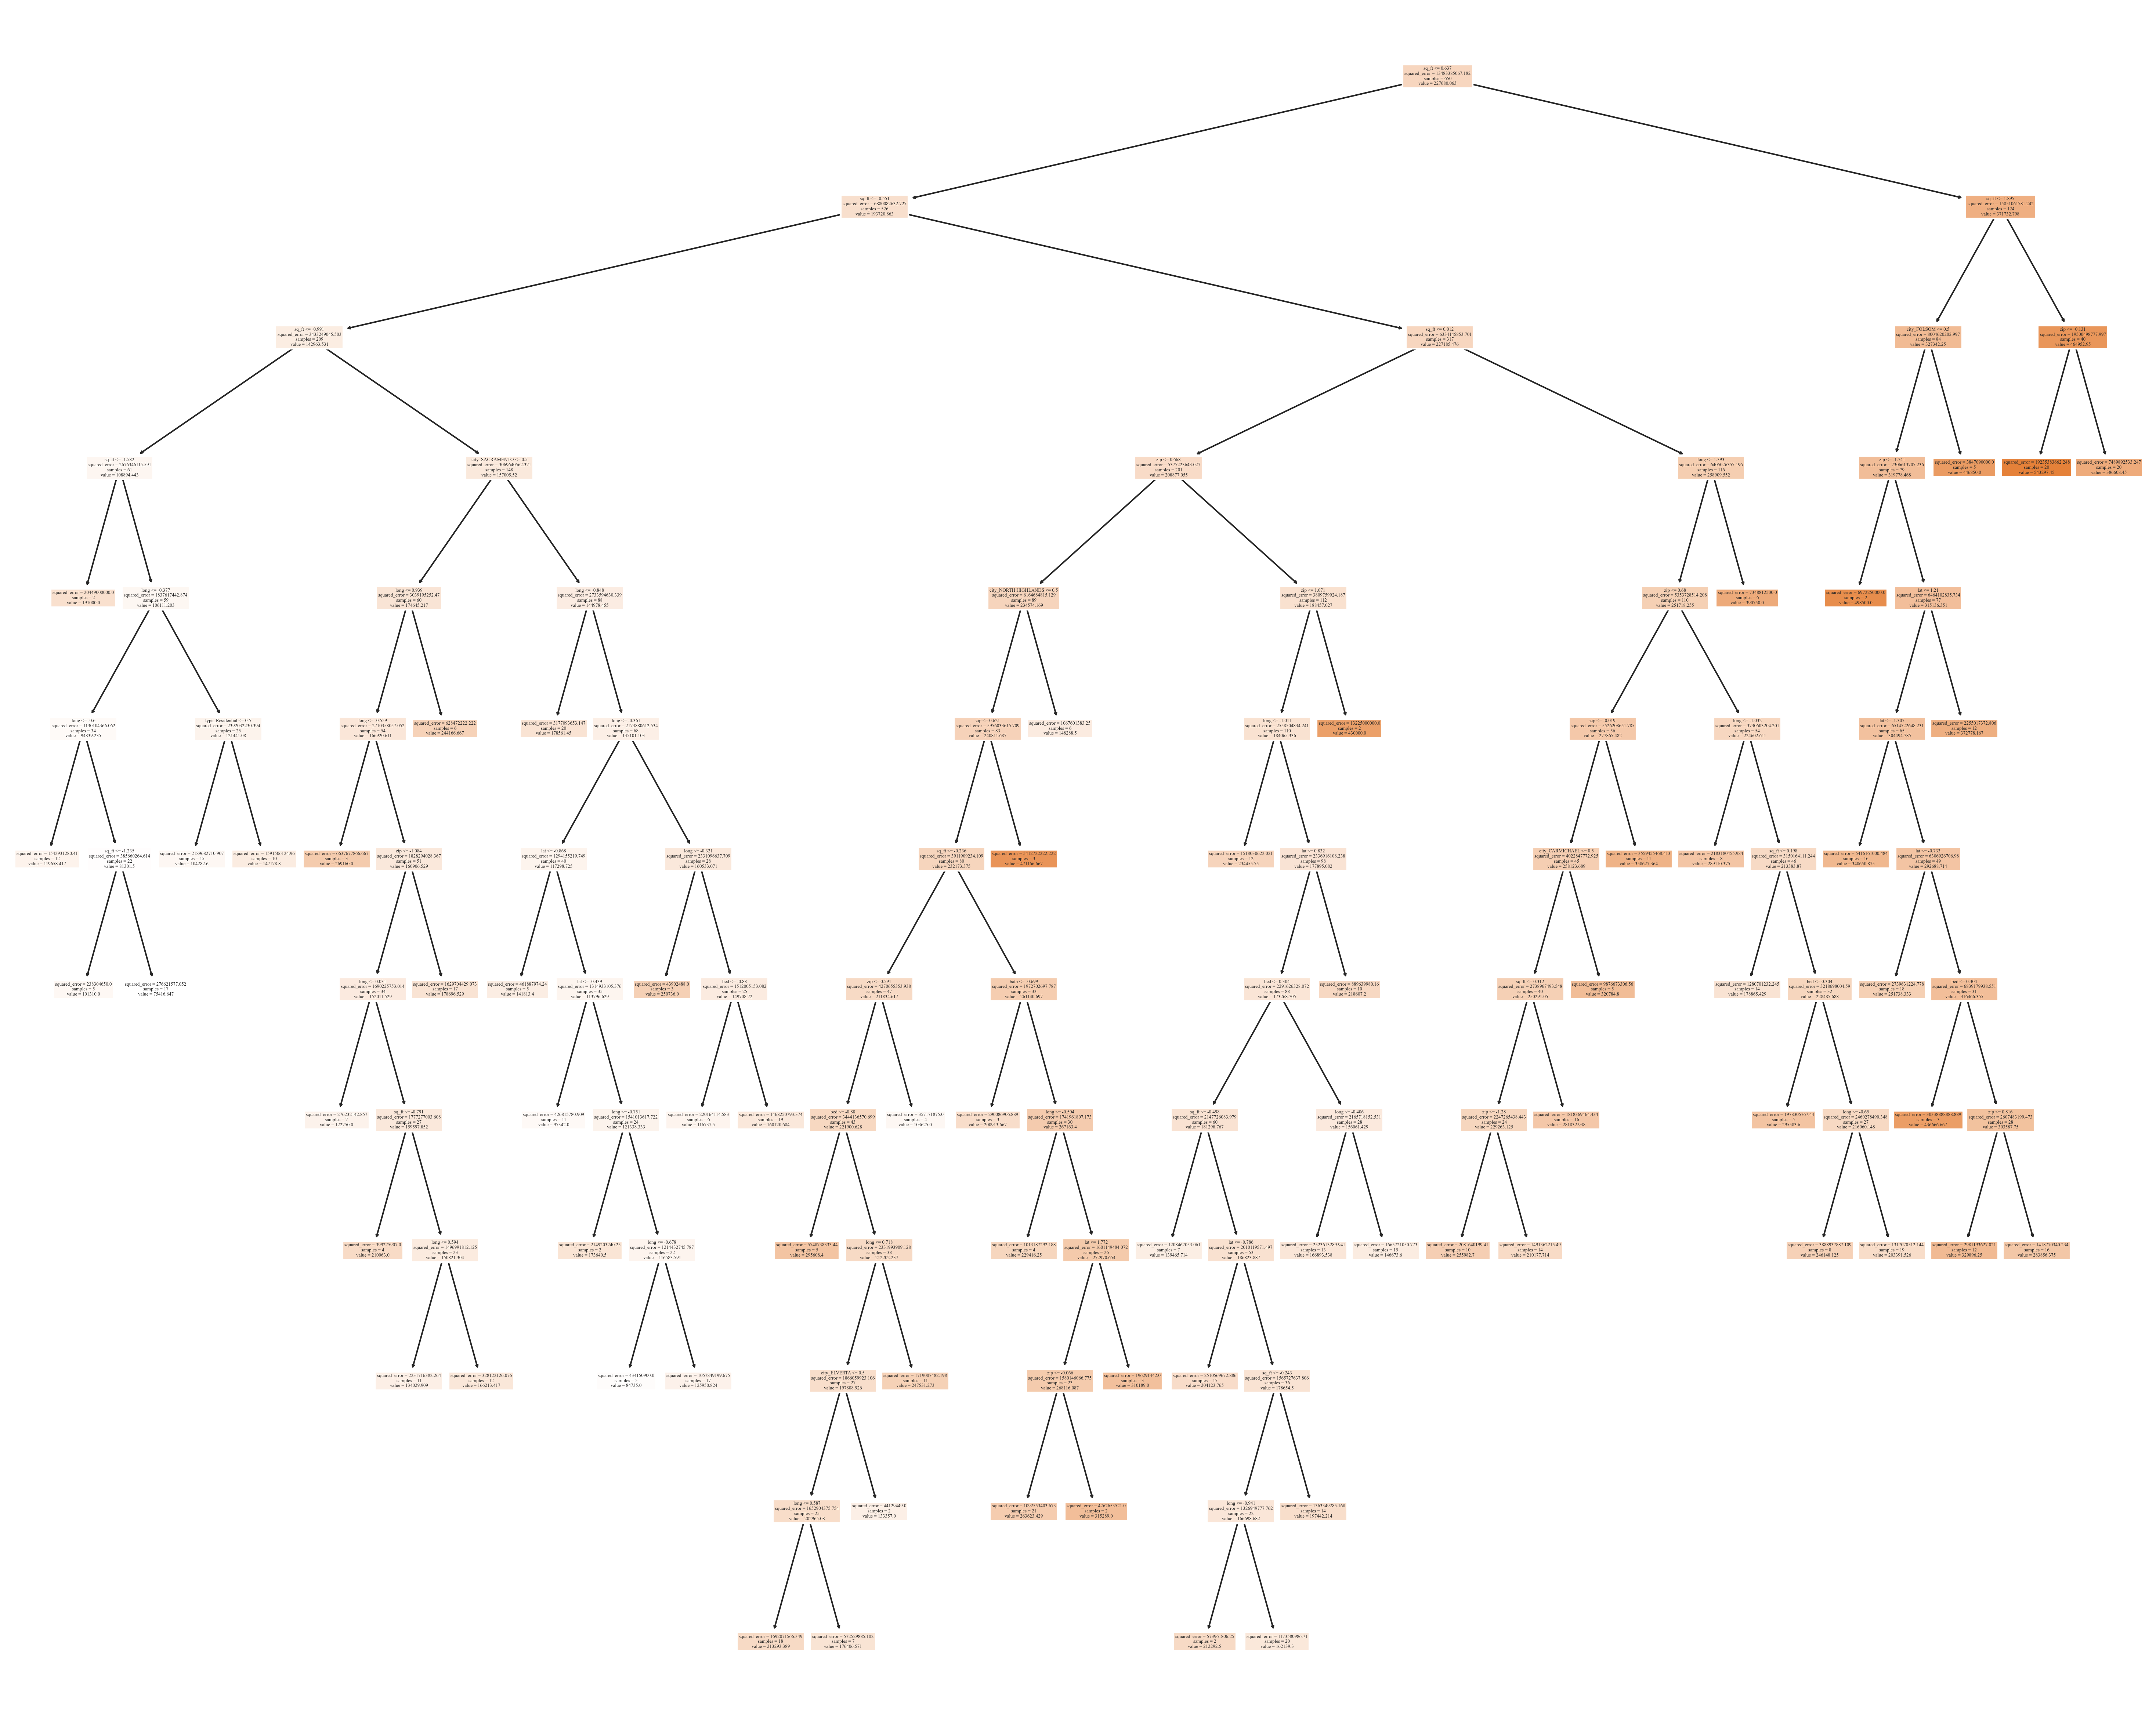

In [81]:
fig = plt.figure(figsize=(25,20), dpi=300)
_ = plot_tree(rgr, 
              feature_names=X_train.columns,  
              class_names=['price'],
              filled=True)

## 6. Random Forest

### 6.1. Parameter tuning: n_estimators

In [82]:
r2_scores = []
estimators = np.linspace(1,200,200).astype(int)

for n in estimators:
    rgr = RandomForestRegressor(n_estimators = n,
                                random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)

    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_n = estimators[np.where(r2_scores == max_score)[0][0]]

print(f'Best n_estimatos is {best_n} with a R2 Score of {max_score}')

Best n_estimatos is 23 with a R2 Score of 0.5871764287864479


### 6.2. Parameter tuning: max_depth

In [83]:
r2_scores = []
depths = np.linspace(1,50,50).astype(int)

for depth in depths:
    rgr = RandomForestRegressor(n_estimators = best_n,
                                max_depth=depth,
                                random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)

    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_depth = depths[np.where(r2_scores == max_score)[0][0]]

print(f'Best max_depth is {best_depth} with a R2 Score of {max_score}')

Best max_depth is 17 with a R2 Score of 0.5919222661249979


### 6.3. Parameter tuning: min_samples_split

In [84]:
r2_scores = []
splits = np.linspace(2, 10, 9).astype(int)

for split in splits:
    rgr = RandomForestRegressor(n_estimators = best_n,
                                max_depth=best_depth,
                                min_samples_split=split,
                                random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)

    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_split = splits[np.where(r2_scores == max_score)[0][0]]

print(f'Best min_samples_split is {best_split} with a R2 Score of {max_score}')

Best min_samples_split is 2 with a R2 Score of 0.5919222661249979


### 6.4. Parameter tuning: min_samples_leaf

In [85]:
r2_scores = []
leaves = np.linspace(1, 10, 10).astype(int)

for leaf in leaves:
    rgr = RandomForestRegressor(n_estimators = best_n,
                                max_depth=best_depth,
                                min_samples_split=best_split,
                                min_samples_leaf=leaf,
                                random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)

    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_leaf = leaves[np.where(r2_scores == max_score)[0][0]]

print(f'Best min_samples_leaf is {best_leaf} with a R2 Score of {max_score}')

Best min_samples_leaf is 1 with a R2 Score of 0.5919222661249979


### 6.5. Parameter tuning: max_features

In [86]:
r2_scores = []
num_of_features = list(range(1, X_est_scaled.shape[1] + 1))

for num in num_of_features:
    rgr = RandomForestRegressor(n_estimators = best_n,
                                max_depth=best_depth,
                                min_samples_split=best_split,
                                min_samples_leaf=best_leaf,
                                max_features=num,
                                random_state=seed)
    rgr.fit(X_est_scaled, y_est)
    y_val_pred = rgr.predict(X_val_scaled)

    score = r2_score(y_val, y_val_pred)
    r2_scores.append(score)

max_score = np.max(r2_scores)
best_max_feature = num_of_features[np.where(r2_scores == max_score)[0][0]]

print(f'Best max_features is {best_max_feature} with a R2 Score of {max_score}')

Best max_features is 37 with a R2 Score of 0.6099533014964976


### 6.6. Fitting the best model with the training set

In [87]:
rgr = RandomForestRegressor(n_estimators = best_n,
                            max_depth=best_depth,
                            min_samples_split=best_split,
                            min_samples_leaf=best_leaf,
                            max_features=best_max_feature,
                            random_state=seed)

rgr.fit(X_train_scaled, y_train)
y_test_pred = rgr.predict(X_test_scaled)
y_train_pred = rgr.predict(X_train_scaled)

RF_rmse_train = calc_rmse(y_train, y_train_pred)
RF_nse_train = calc_nse(y_train, y_train_pred)
RF_r2_train = r2_score(y_train, y_train_pred)
RF_mae_train = mean_absolute_error(y_train, y_train_pred)

RF_rmse = calc_rmse(y_test, y_test_pred)
RF_nse = calc_nse(y_test, y_test_pred)
RF_r2 = r2_score(y_test, y_test_pred)
RF_mae = mean_absolute_error(y_test, y_test_pred)

In [88]:
print('Train RMSE:', RF_rmse_train)
print('Train NSE:', RF_nse_train)
print('Train R2 Score:', RF_r2_train)
print('Train MAE:', RF_mae_train)

Train RMSE: 29138.825265612184
Train NSE: 0.9370283401661151
Train R2 Score: 0.9370283401661151
Train MAE: 20137.759160014964


In [89]:
print('Test RMSE:', RF_rmse)
print('Test NSE:', RF_nse)
print('Test R2 Score:', RF_r2)
print('Test MAE:', RF_mae)

Test RMSE: 87862.7915182229
Test NSE: 0.5574831774698077
Test R2 Score: 0.5574831774698077
Test MAE: 57135.460194328734


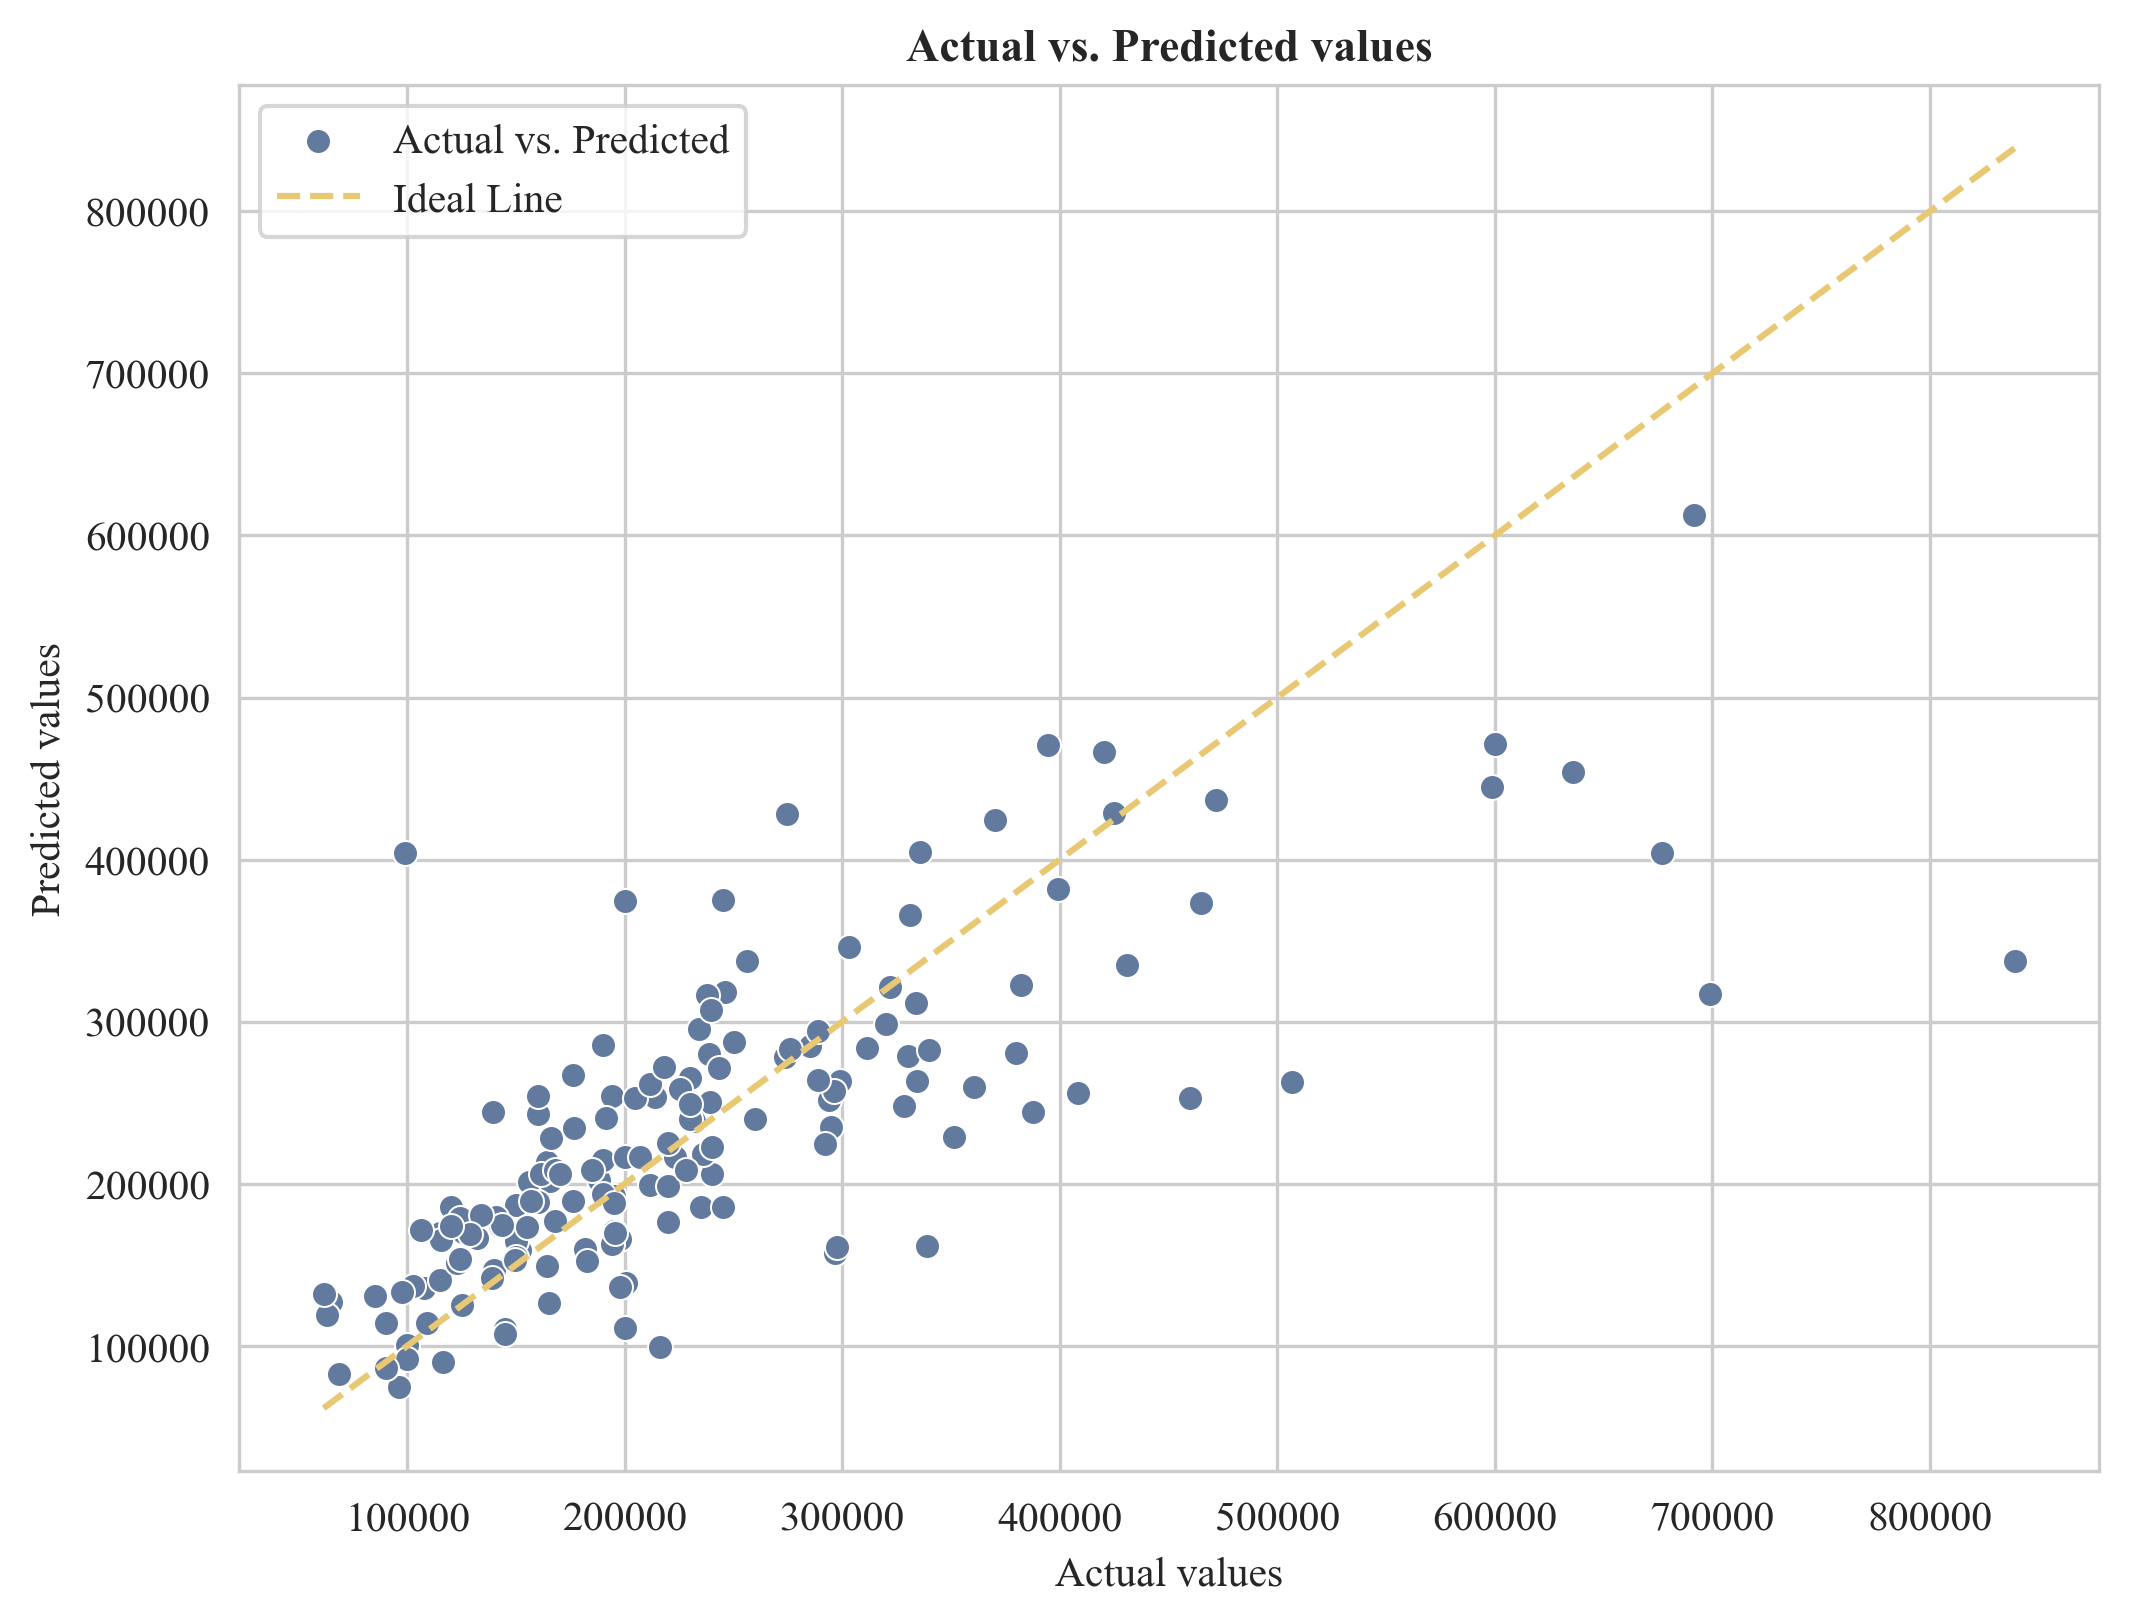

In [93]:
plt.figure(figsize=(8, 6), dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values', fontweight='bold', fontsize=11)
plt.legend()
plt.show()

## 7. Final Results

In [91]:
final_result = pd.DataFrame({'Model':['Linear Regression',
                                      'K-Nearest Neighbors Regression',
                                      'Decision Tree Regression',
                                      'Random Forest Regression'],
                             'Train RMSE':[LR_rmse_train,KNN_rmse_train,DTR_rmse_train,RF_rmse_train],
                             'Test RMSE':[LR_rmse,KNN_rmse,DTR_rmse,RF_rmse],
                             'Train R2 Score':[LR_r2_train,KNN_r2_train,DTR_r2_train,RF_r2_train],
                             'Test R2 Score':[LR_r2,KNN_r2,DTR_r2,RF_r2],
                             'Train MAE':[LR_mae_train,KNN_mae_train,DTR_mae_train,RF_mae_train],
                             'Test MAE':[LR_mae,KNN_mae,DTR_mae,RF_mae],
                             'Train NSE':[LR_nse_train,KNN_nse_train,DTR_nse_train,RF_nse_train],
                             'Test NSE':[LR_nse,KNN_nse,DTR_nse,RF_nse]})
final_result

Model    Train RMSE     Test RMSE  Train R2 Score  \
0               Linear Regression  66146.574264  87194.585602        0.675499   
1  K-Nearest Neighbors Regression  52633.804701  88255.029316        0.794538   
2        Decision Tree Regression  53440.596470  95228.490472        0.788191   
3        Random Forest Regression  29138.825266  87862.791518        0.937028   

   Test R2 Score     Train MAE      Test MAE  Train NSE  Test NSE  
0       0.564188  47806.803527  55760.645219   0.675499  0.564188  
1       0.553523  38061.434359  59984.394683   0.794538  0.553523  
2       0.480179  37705.344047  65800.945846   0.788191  0.480179  
3       0.557483  20137.759160  57135.460194   0.937028  0.557483